/tmp/ipykernel_1124385/1081677035.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
/tmp/ipykernel_1124385/1081677035.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_1124385/1081677035.py:100: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False


📊 Solution Conciseness (Average Plan Length)
method                                     cot_k1       cot_k3       cot_k5       spiral
dataset       model                                                                     
dailylifeapis deepseek_v2_5           2.82 ± 0.17  2.84 ± 0.15  2.82 ± 0.15  2.74 ± 0.15
              llama_3_3_70b_instruct  3.04 ± 0.17  3.10 ± 0.21  3.09 ± 0.21  2.94 ± 0.13
              llama_4                 2.89 ± 0.18  2.89 ± 0.18  2.92 ± 0.20  2.84 ± 0.13
              phi                     2.77 ± 0.19  2.80 ± 0.19  2.81 ± 0.18  2.69 ± 0.14
              qwen2_5_72b_instruct    2.88 ± 0.19  2.87 ± 0.21  2.91 ± 0.20  2.73 ± 0.16
huggingface   deepseek_v2_5           2.71 ± 0.08  2.60 ± 0.19  2.70 ± 0.07  2.30 ± 0.05
              llama_3_3_70b_instruct  2.77 ± 0.05  2.80 ± 0.10  2.78 ± 0.05  2.28 ± 0.06
              llama_4                 2.57 ± 0.06  2.58 ± 0.07  2.54 ± 0.09  2.35 ± 0.04
              phi                     2.53 ± 0.06  2.57 ± 0.08  

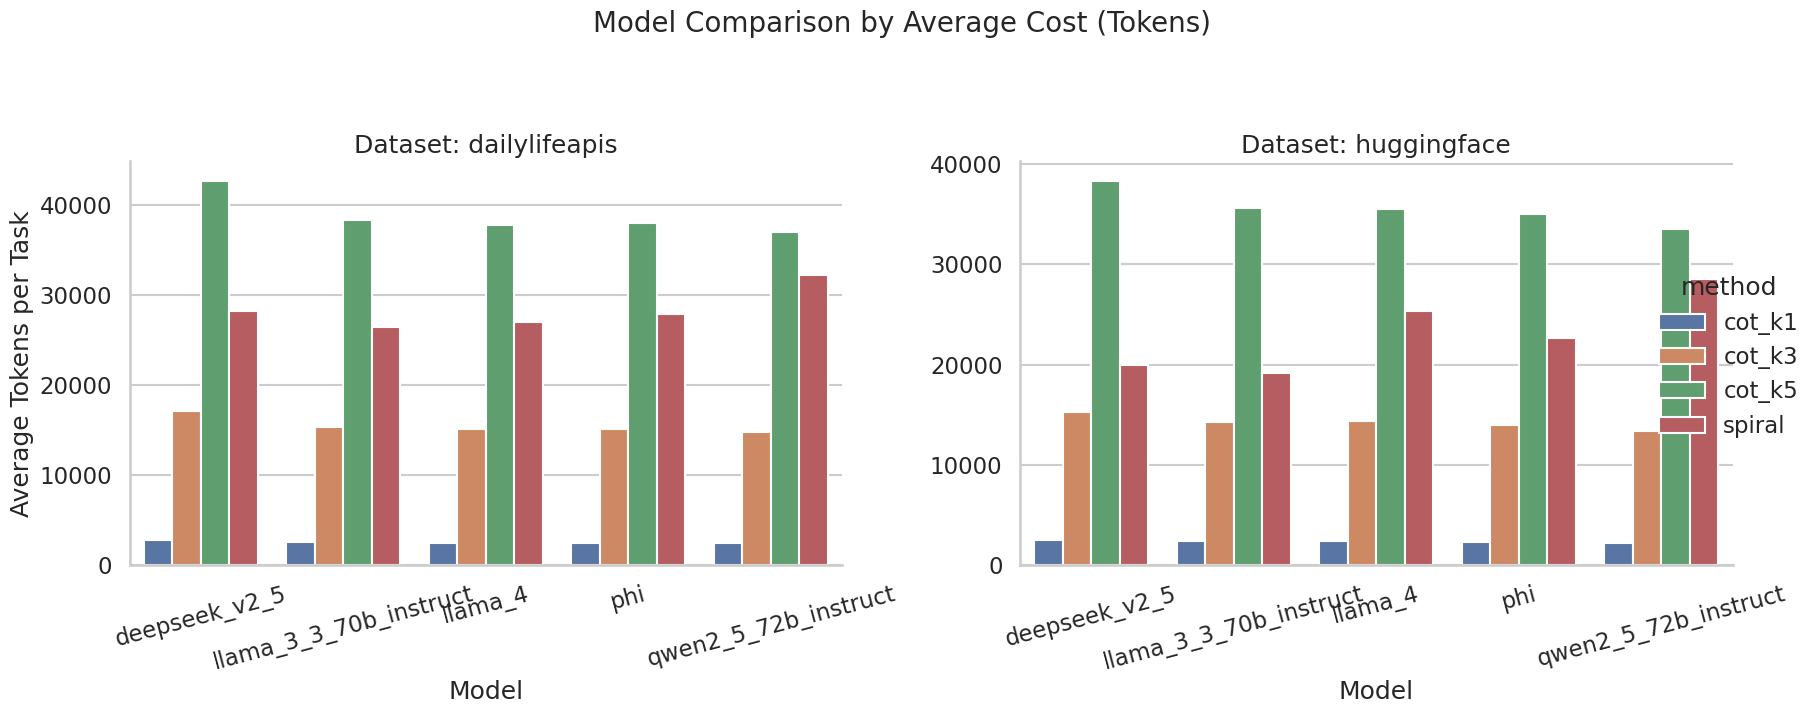

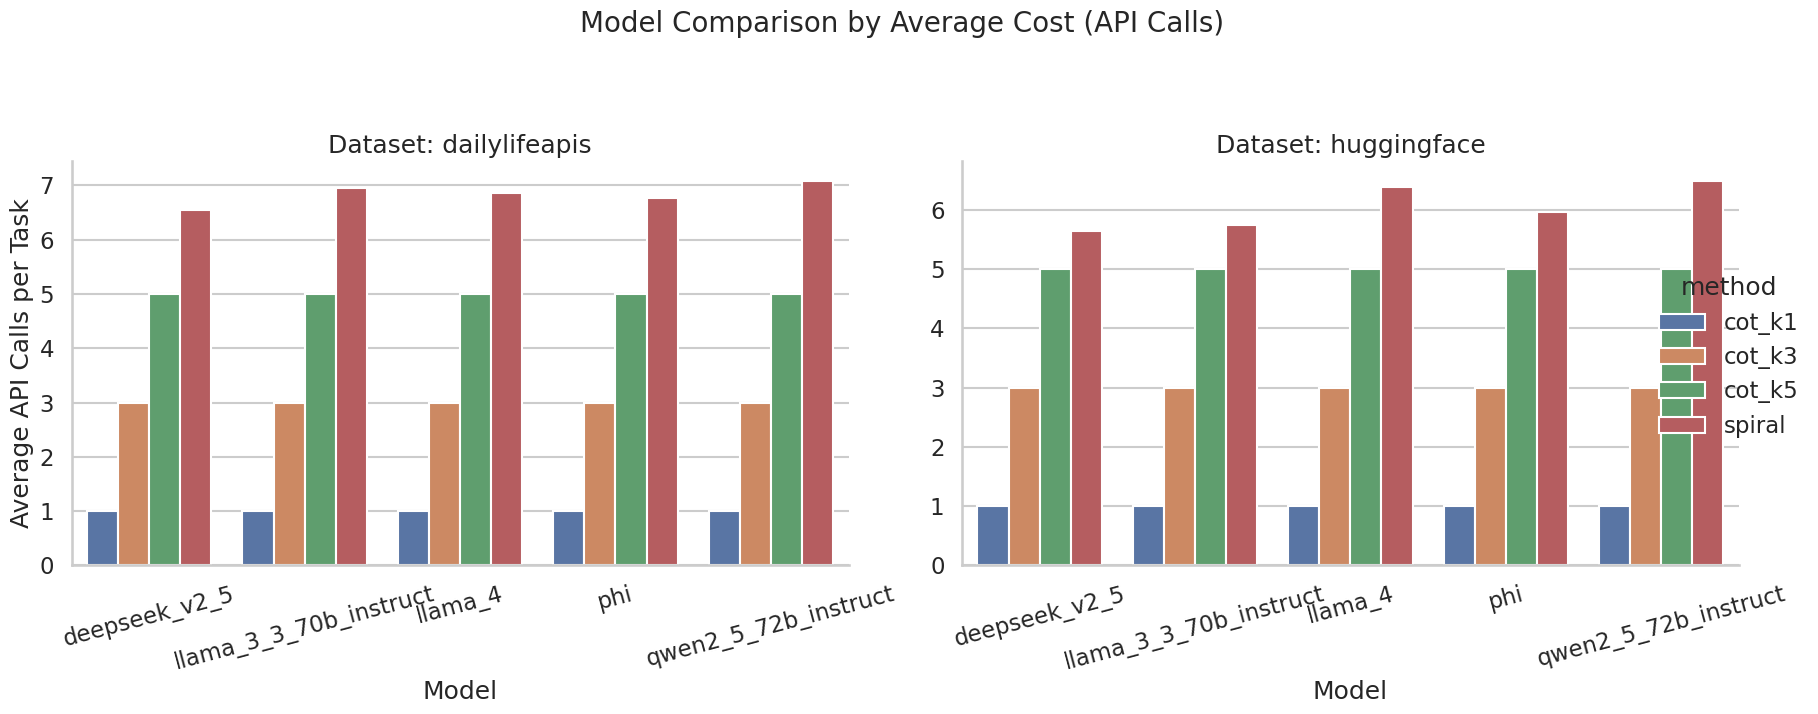

In [1]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Robust Data Parsing ---
# Captures all necessary metrics for both the table and the plots.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]
            
            run_id_match = re.search(r'run_seed_(\d+)', str(file_path))
            run_id = run_id_match.group(1) if run_id_match else file_path.parent.name

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                llm_calls = None
                total_tokens = None

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_calls = search_process.get('expansion_llm_calls', 0)
                    sim_calls = search_process.get('simulation_llm_calls', 0)
                    crit_calls = search_process.get('critic_llm_calls', 0)
                    llm_calls = exp_calls + sim_calls + crit_calls
                    
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                else: # Baseline methods
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    llm_calls = reasoning_cost.get('llm_calls')
                    total_tokens = reasoning_cost.get('total_llm_tokens')

                detailed_data.append({
                    'run_id': str(run_id),
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Solution Conciseness': metrics.get('plan_length'),
                    'Tokens': total_tokens,
                    'API Calls': llm_calls
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna().copy()

models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Generate and Print Solution Conciseness Table ---
if not df_filtered.empty:
    # Set categorical types to enforce order
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Calculate mean per run
    run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
    
    # Calculate final mean and std across runs
    agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
    
    # Format the string for printing
    agg_df_conciseness['Formatted'] = agg_df_conciseness.apply(
        lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1
    )

    # Pivot to create the final table structure
    conciseness_table = agg_df_conciseness.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values='Formatted',
        aggfunc='first'
    )
    
    print("\n" + "="*80)
    print("📊 Solution Conciseness (Average Plan Length)")
    print("="*80)
    print(conciseness_table.to_string())
    print("\n")

    # --- 4. Generate Bar Plots for Average Cost ---
    
    # Aggregate data for plotting
    plot_agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Tokens': 'mean',
        'API Calls': 'mean'
    }).reset_index()

    sns.set_theme(style="whitegrid", context="talk")

    # Plot 1: Average Tokens
    g_tokens = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model',
        y='Tokens',
        hue='method',
        col='dataset',
        hue_order=methods_to_keep,
        order=sorted(models_to_keep),
        height=7,
        aspect=1.2,
        sharey=False # Allow y-axes to have different scales
    )
    g_tokens.fig.suptitle('Model Comparison by Average Cost (Tokens)', y=1.03, fontsize=20)
    g_tokens.set_axis_labels("Model", "Average Tokens per Task")
    g_tokens.set_titles("Dataset: {col_name}")
    g_tokens.set_xticklabels(rotation=15)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # Plot 2: Average API Calls
    g_calls = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model',
        y='API Calls',
        hue='method',
        col='dataset',
        hue_order=methods_to_keep,
        order=sorted(models_to_keep),
        height=7,
        aspect=1.2,
        sharey=False # Allow y-axes to have different scales
    )
    g_calls.fig.suptitle('Model Comparison by Average Cost (API Calls)', y=1.03, fontsize=20)
    g_calls.set_axis_labels("Model", "Average API Calls per Task")
    g_calls.set_titles("Dataset: {col_name}")
    g_calls.set_xticklabels(rotation=15)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

else:
    print("🔴 No data available for analysis after filtering.")

/tmp/ipykernel_1124385/473271306.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
/tmp/ipykernel_1124385/473271306.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_1124385/473271306.py:100: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to


📊 Solution Conciseness (Average Plan Length)
method                                     cot_k1       cot_k3       cot_k5       spiral
dataset       model                                                                     
dailylifeapis deepseek_v2_5           2.82 ± 0.17  2.84 ± 0.15  2.82 ± 0.15  2.74 ± 0.15
              llama_3_3_70b_instruct  3.04 ± 0.17  3.10 ± 0.21  3.09 ± 0.21  2.94 ± 0.13
              llama_4                 2.89 ± 0.18  2.89 ± 0.18  2.92 ± 0.20  2.84 ± 0.13
              phi                     2.77 ± 0.19  2.80 ± 0.19  2.81 ± 0.18  2.69 ± 0.14
              qwen2_5_72b_instruct    2.88 ± 0.19  2.87 ± 0.21  2.91 ± 0.20  2.73 ± 0.16
huggingface   deepseek_v2_5           2.71 ± 0.08  2.60 ± 0.19  2.70 ± 0.07  2.30 ± 0.05
              llama_3_3_70b_instruct  2.77 ± 0.05  2.80 ± 0.10  2.78 ± 0.05  2.28 ± 0.06
              llama_4                 2.57 ± 0.06  2.58 ± 0.07  2.54 ± 0.09  2.35 ± 0.04
              phi                     2.53 ± 0.06  2.57 ± 0.08  

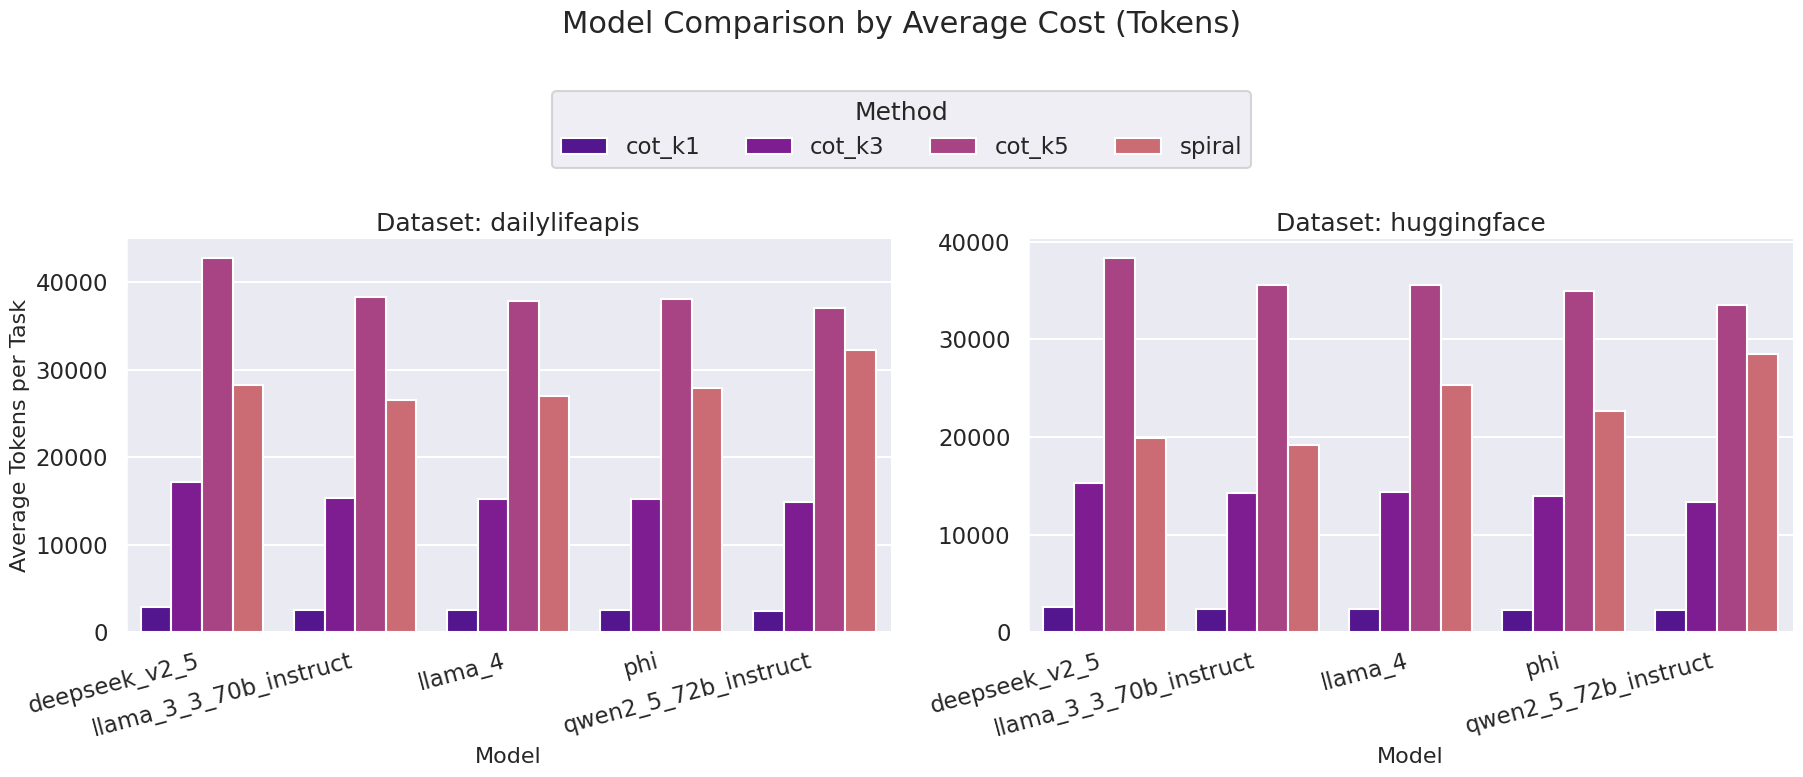

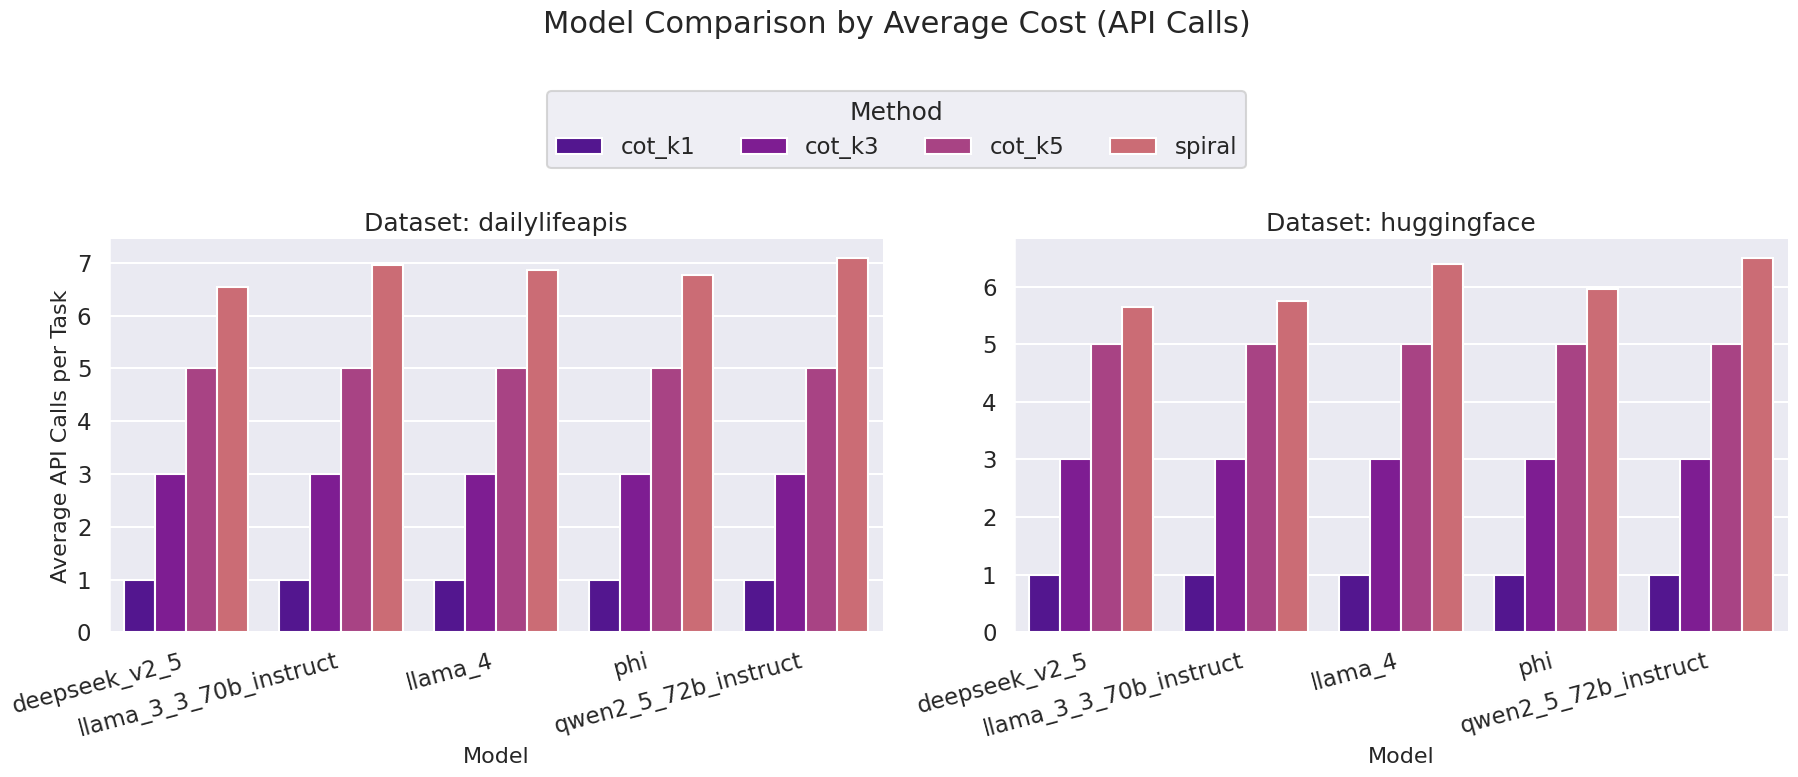

In [2]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Robust Data Parsing ---
# Captures all necessary metrics for both the table and the plots.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]
            
            run_id_match = re.search(r'run_seed_(\d+)', str(file_path))
            run_id = run_id_match.group(1) if run_id_match else file_path.parent.name

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                llm_calls = None
                total_tokens = None

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_calls = search_process.get('expansion_llm_calls', 0)
                    sim_calls = search_process.get('simulation_llm_calls', 0)
                    crit_calls = search_process.get('critic_llm_calls', 0)
                    llm_calls = exp_calls + sim_calls + crit_calls
                    
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                else: # Baseline methods
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    llm_calls = reasoning_cost.get('llm_calls')
                    total_tokens = reasoning_cost.get('total_llm_tokens')

                detailed_data.append({
                    'run_id': str(run_id),
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Solution Conciseness': metrics.get('plan_length'),
                    'Tokens': total_tokens,
                    'API Calls': llm_calls
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna().copy()

models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Generate and Print Solution Conciseness Table ---
if not df_filtered.empty:
    # Set categorical types to enforce order
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Calculate mean per run
    run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
    
    # Calculate final mean and std across runs
    agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
    
    # Format the string for printing
    agg_df_conciseness['Formatted'] = agg_df_conciseness.apply(
        lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1
    )

    # Pivot to create the final table structure
    conciseness_table = agg_df_conciseness.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values='Formatted',
        aggfunc='first'
    )
    
    print("\n" + "="*80)
    print("📊 Solution Conciseness (Average Plan Length)")
    print("="*80)
    print(conciseness_table.to_string())
    print("\n")

    # --- 4. Generate Bar Plots for Average Cost ---
    
    # Aggregate data for plotting
    plot_agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Tokens': 'mean',
        'API Calls': 'mean'
    }).reset_index()

    # --- MODIFICATION: Beautify plots ---
    sns.set_theme(style="darkgrid", context="talk", palette="plasma")

    # Plot 1: Average Tokens
    g_tokens = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model',
        y='Tokens',
        hue='method',
        col='dataset',
        hue_order=methods_to_keep,
        order=sorted(models_to_keep),
        height=7,
        aspect=1.2,
        sharey=False
    )
    g_tokens.fig.suptitle('Model Comparison by Average Cost (Tokens)', y=1.12, fontsize=22)
    sns.move_legend(
        g_tokens, "upper center",
        bbox_to_anchor=(.5, 1.02), ncol=len(methods_to_keep), title='Method', frameon=True
    )
    g_tokens.set_axis_labels("Model", "Average Tokens per Task", fontsize=16)
    g_tokens.set_titles("Dataset: {col_name}", size=18)
    g_tokens.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Plot 2: Average API Calls
    g_calls = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model',
        y='API Calls',
        hue='method',
        col='dataset',
        hue_order=methods_to_keep,
        order=sorted(models_to_keep),
        height=7,
        aspect=1.2,
        sharey=False
    )
    g_calls.fig.suptitle('Model Comparison by Average Cost (API Calls)', y=1.12, fontsize=22)
    sns.move_legend(
        g_calls, "upper center",
        bbox_to_anchor=(.5, 1.02), ncol=len(methods_to_keep), title='Method', frameon=True
    )
    g_calls.set_axis_labels("Model", "Average API Calls per Task", fontsize=16)
    g_calls.set_titles("Dataset: {col_name}", size=18)
    g_calls.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("🔴 No data available for analysis after filtering.")

/tmp/ipykernel_1124385/1006895860.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
/tmp/ipykernel_1124385/1006895860.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_1124385/1006895860.py:100: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False


📊 Solution Conciseness (Average Plan Length)
method                                     cot_k1       cot_k3       cot_k5       spiral
dataset       model                                                                     
dailylifeapis deepseek_v2_5           2.82 ± 0.17  2.84 ± 0.15  2.82 ± 0.15  2.74 ± 0.15
              llama_3_3_70b_instruct  3.04 ± 0.17  3.10 ± 0.21  3.09 ± 0.21  2.94 ± 0.13
              llama_4                 2.89 ± 0.18  2.89 ± 0.18  2.92 ± 0.20  2.84 ± 0.13
              phi                     2.77 ± 0.19  2.80 ± 0.19  2.81 ± 0.18  2.69 ± 0.14
              qwen2_5_72b_instruct    2.88 ± 0.19  2.87 ± 0.21  2.91 ± 0.20  2.73 ± 0.16
huggingface   deepseek_v2_5           2.71 ± 0.08  2.60 ± 0.19  2.70 ± 0.07  2.30 ± 0.05
              llama_3_3_70b_instruct  2.77 ± 0.05  2.80 ± 0.10  2.78 ± 0.05  2.28 ± 0.06
              llama_4                 2.57 ± 0.06  2.58 ± 0.07  2.54 ± 0.09  2.35 ± 0.04
              phi                     2.53 ± 0.06  2.57 ± 0.08  

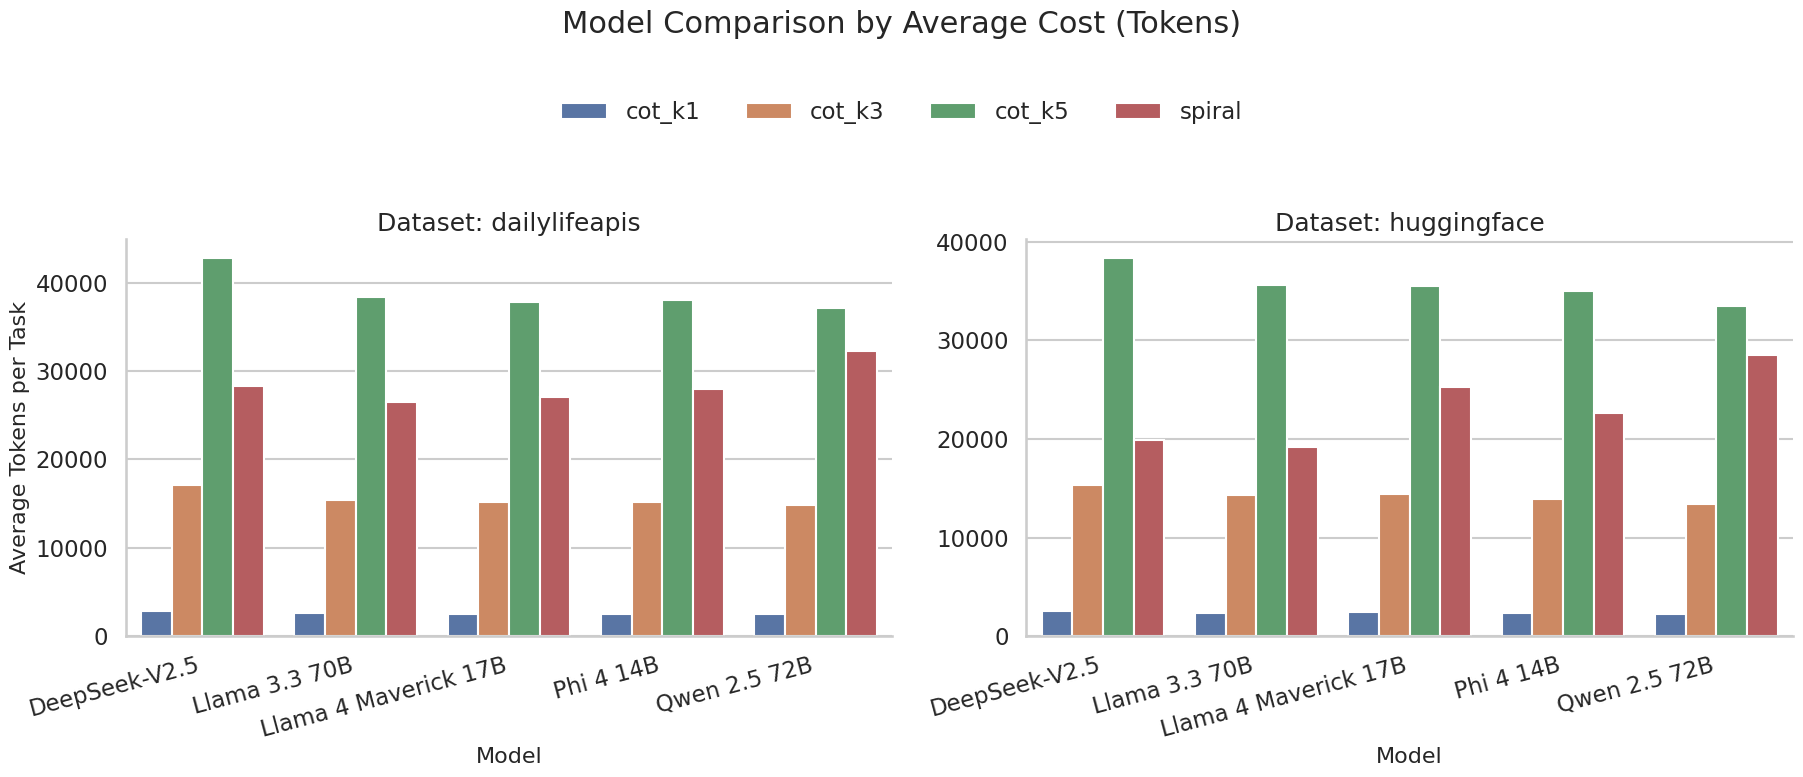

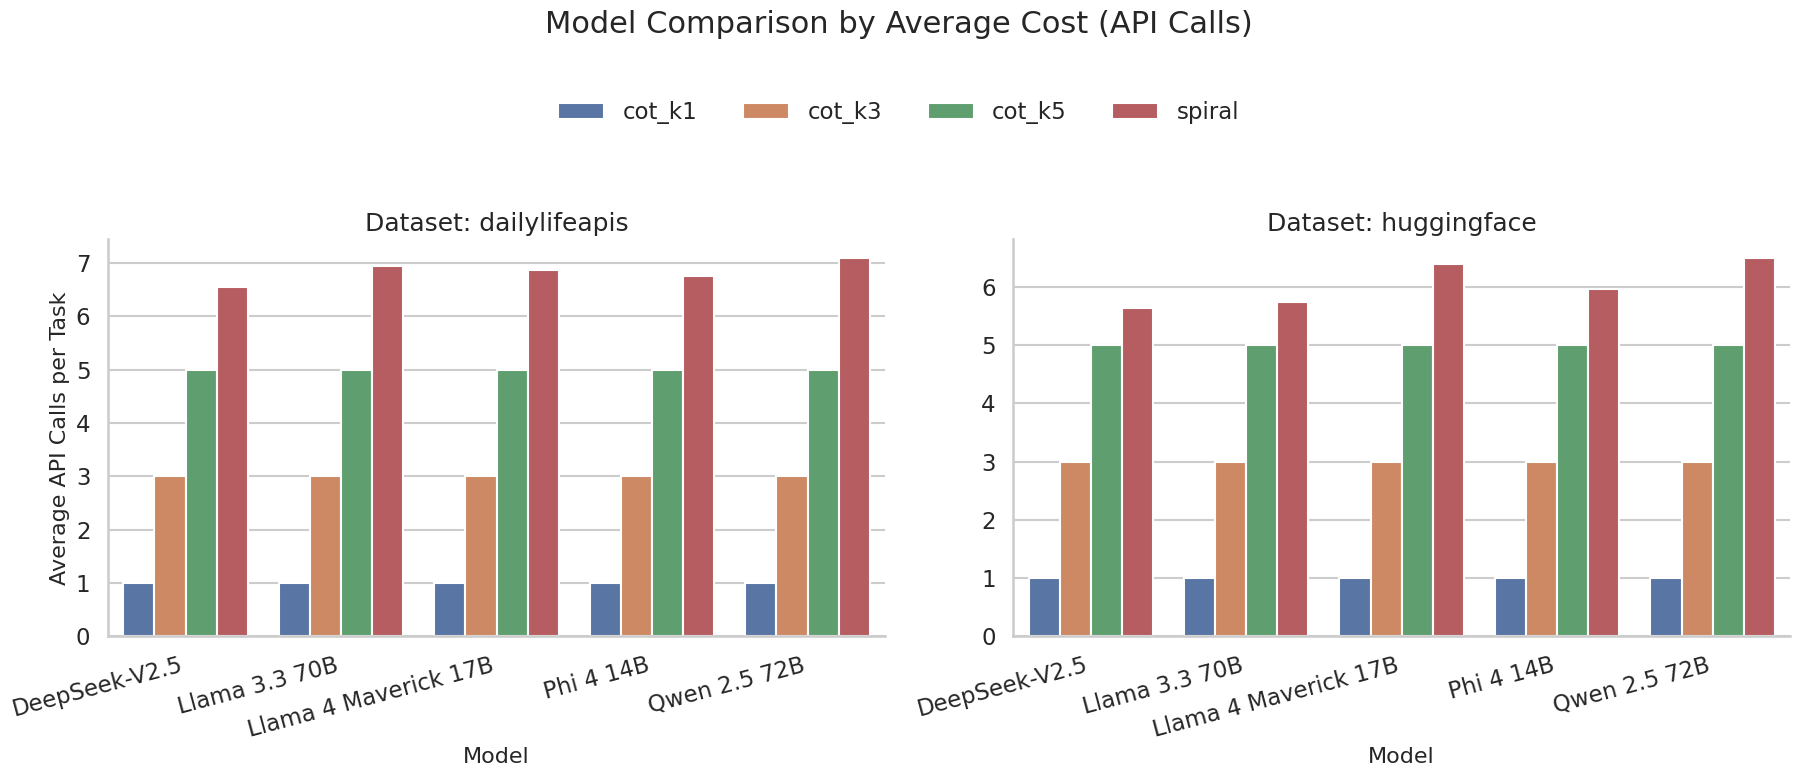

In [3]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Robust Data Parsing ---
# Captures all necessary metrics for both the table and the plots.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]
            
            run_id_match = re.search(r'run_seed_(\d+)', str(file_path))
            run_id = run_id_match.group(1) if run_id_match else file_path.parent.name

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                llm_calls = None
                total_tokens = None

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_calls = search_process.get('expansion_llm_calls', 0)
                    sim_calls = search_process.get('simulation_llm_calls', 0)
                    crit_calls = search_process.get('critic_llm_calls', 0)
                    llm_calls = exp_calls + sim_calls + crit_calls
                    
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                else: # Baseline methods
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    llm_calls = reasoning_cost.get('llm_calls')
                    total_tokens = reasoning_cost.get('total_llm_tokens')

                detailed_data.append({
                    'run_id': str(run_id),
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Solution Conciseness': metrics.get('plan_length'),
                    'Tokens': total_tokens,
                    'API Calls': llm_calls
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna().copy()

models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Generate and Print Solution Conciseness Table ---
if not df_filtered.empty:
    # Set categorical types to enforce order
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Calculate mean per run
    run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
    
    # Calculate final mean and std across runs
    agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
    
    # Format the string for printing
    agg_df_conciseness['Formatted'] = agg_df_conciseness.apply(
        lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1
    )

    # Pivot to create the final table structure
    conciseness_table = agg_df_conciseness.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values='Formatted',
        aggfunc='first'
    )
    
    print("\n" + "="*80)
    print("📊 Solution Conciseness (Average Plan Length)")
    print("="*80)
    print(conciseness_table.to_string())
    print("\n")

    # --- 4. Generate Bar Plots for Average Cost ---
    
    # Aggregate data for plotting
    plot_agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Tokens': 'mean',
        'API Calls': 'mean'
    }).reset_index()

    # --- MODIFICATION: Beautify plots ---
    sns.set_theme(style="whitegrid", context="talk") # Reverted to a clean, standard theme

    # Map for aligned model names
    model_name_map = {
        'deepseek_v2_5': 'DeepSeek-V2.5',
        'llama_3_3_70b_instruct': 'Llama 3.3 70B',
        'llama_4': 'Llama 4 Maverick 17B',
        'phi': 'Phi 4 14B',
        'qwen2_5_72b_instruct': 'Qwen 2.5 72B'
    }
    plot_agg_df['model_long_name'] = plot_agg_df['model'].map(model_name_map)
    model_order = [model_name_map[m] for m in sorted(models_to_keep)]


    # Plot 1: Average Tokens
    g_tokens = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='Tokens',
        hue='method',
        col='dataset',
        hue_order=methods_to_keep,
        order=model_order,
        height=7,
        aspect=1.2,
        sharey=False
    )
    g_tokens.fig.suptitle('Model Comparison by Average Cost (Tokens)', y=1.12, fontsize=22)
    sns.move_legend(
        g_tokens, "upper center",
        bbox_to_anchor=(.5, 1.02), ncol=len(methods_to_keep), title=None, frameon=False
    )
    g_tokens.set_axis_labels("Model", "Average Tokens per Task", fontsize=16)
    g_tokens.set_titles("Dataset: {col_name}", size=18)
    g_tokens.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Plot 2: Average API Calls
    g_calls = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='API Calls',
        hue='method',
        col='dataset',
        hue_order=methods_to_keep,
        order=model_order,
        height=7,
        aspect=1.2,
        sharey=False
    )
    g_calls.fig.suptitle('Model Comparison by Average Cost (API Calls)', y=1.12, fontsize=22)
    sns.move_legend(
        g_calls, "upper center",
        bbox_to_anchor=(.5, 1.02), ncol=len(methods_to_keep), title=None, frameon=False
    )
    g_calls.set_axis_labels("Model", "Average API Calls per Task", fontsize=16)
    g_calls.set_titles("Dataset: {col_name}", size=18)
    g_calls.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("🔴 No data available for analysis after filtering.")



/tmp/ipykernel_1124385/2693839281.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
/tmp/ipykernel_1124385/2693839281.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_1124385/2693839281.py:100: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False


📊 Solution Conciseness (Average Plan Length)
method                                     cot_k1       cot_k3       cot_k5       spiral
dataset       model                                                                     
dailylifeapis deepseek_v2_5           2.82 ± 0.17  2.84 ± 0.15  2.82 ± 0.15  2.74 ± 0.15
              llama_3_3_70b_instruct  3.04 ± 0.17  3.10 ± 0.21  3.09 ± 0.21  2.94 ± 0.13
              llama_4                 2.89 ± 0.18  2.89 ± 0.18  2.92 ± 0.20  2.84 ± 0.13
              phi                     2.77 ± 0.19  2.80 ± 0.19  2.81 ± 0.18  2.69 ± 0.14
              qwen2_5_72b_instruct    2.88 ± 0.19  2.87 ± 0.21  2.91 ± 0.20  2.73 ± 0.16
huggingface   deepseek_v2_5           2.71 ± 0.08  2.60 ± 0.19  2.70 ± 0.07  2.30 ± 0.05
              llama_3_3_70b_instruct  2.77 ± 0.05  2.80 ± 0.10  2.78 ± 0.05  2.28 ± 0.06
              llama_4                 2.57 ± 0.06  2.58 ± 0.07  2.54 ± 0.09  2.35 ± 0.04
              phi                     2.53 ± 0.06  2.57 ± 0.08  

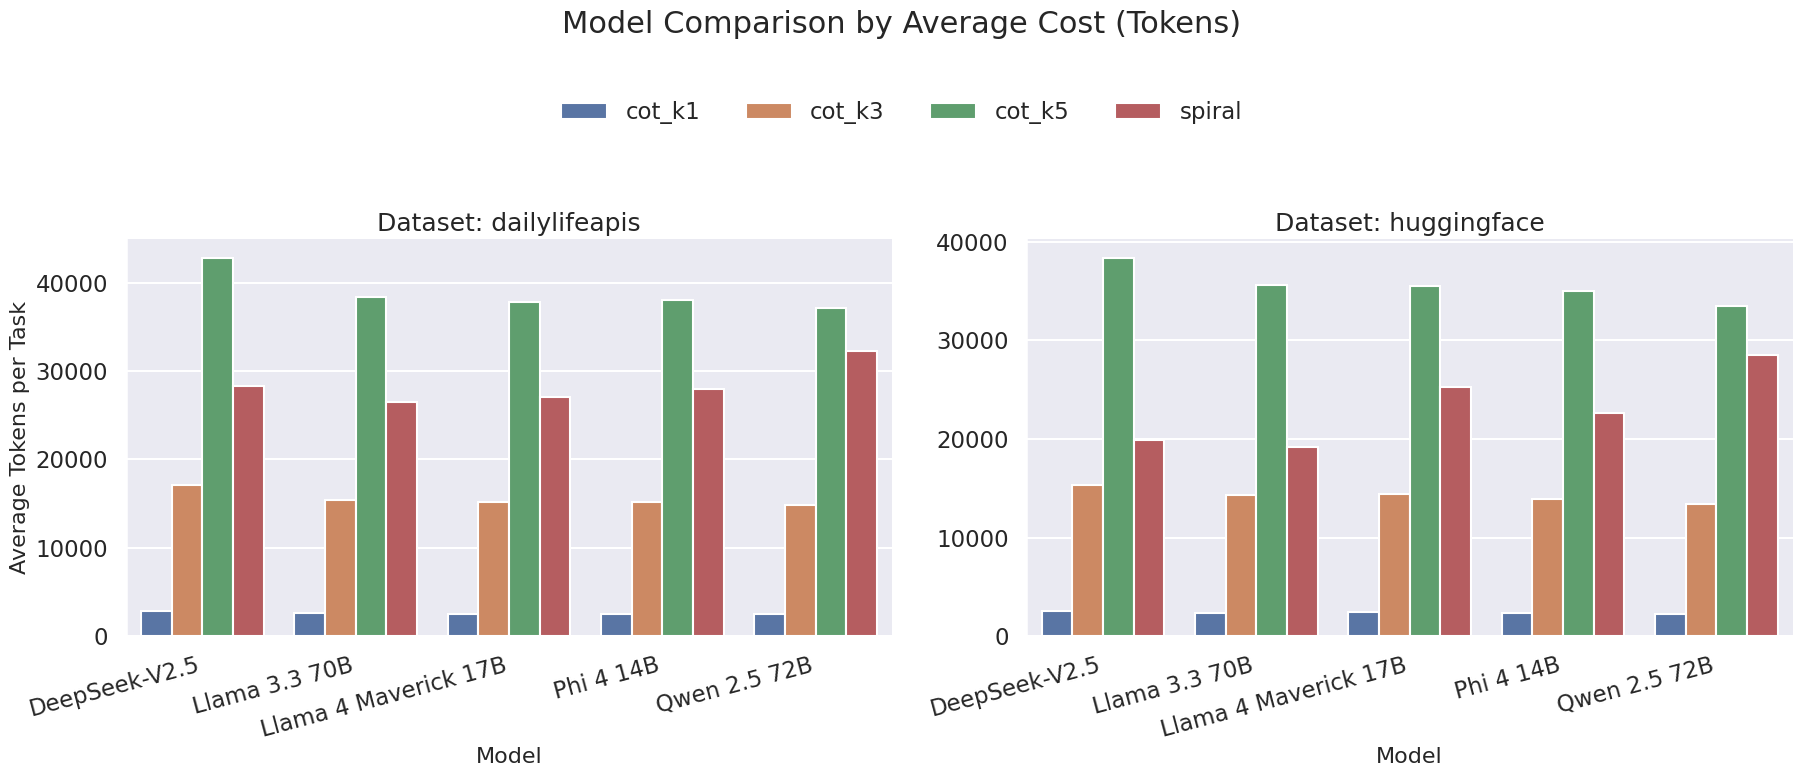

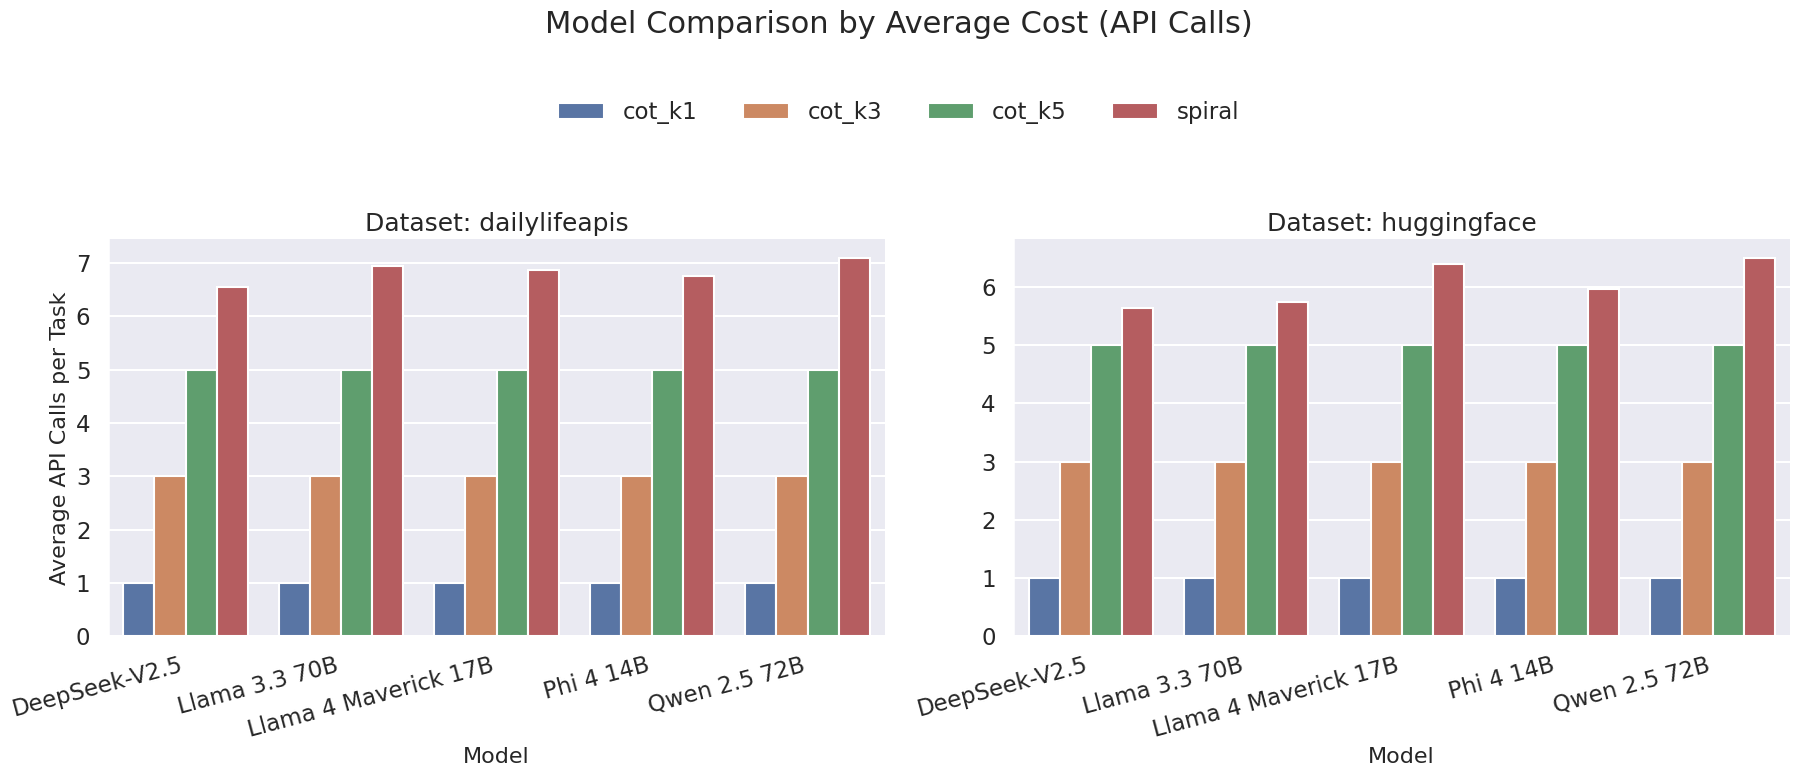

In [4]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Robust Data Parsing ---
# Captures all necessary metrics for both the table and the plots.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]
            
            run_id_match = re.search(r'run_seed_(\d+)', str(file_path))
            run_id = run_id_match.group(1) if run_id_match else file_path.parent.name

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                llm_calls = None
                total_tokens = None

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_calls = search_process.get('expansion_llm_calls', 0)
                    sim_calls = search_process.get('simulation_llm_calls', 0)
                    crit_calls = search_process.get('critic_llm_calls', 0)
                    llm_calls = exp_calls + sim_calls + crit_calls
                    
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                else: # Baseline methods
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    llm_calls = reasoning_cost.get('llm_calls')
                    total_tokens = reasoning_cost.get('total_llm_tokens')

                detailed_data.append({
                    'run_id': str(run_id),
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Solution Conciseness': metrics.get('plan_length'),
                    'Tokens': total_tokens,
                    'API Calls': llm_calls
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna().copy()

models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Generate and Print Solution Conciseness Table ---
if not df_filtered.empty:
    # Set categorical types to enforce order
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Calculate mean per run
    run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
    
    # Calculate final mean and std across runs
    agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
    
    # Format the string for printing
    agg_df_conciseness['Formatted'] = agg_df_conciseness.apply(
        lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1
    )

    # Pivot to create the final table structure
    conciseness_table = agg_df_conciseness.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values='Formatted',
        aggfunc='first'
    )
    
    print("\n" + "="*80)
    print("📊 Solution Conciseness (Average Plan Length)")
    print("="*80)
    print(conciseness_table.to_string())
    print("\n")

    # --- 4. Generate Bar Plots for Average Cost ---
    
    # Aggregate data for plotting
    plot_agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Tokens': 'mean',
        'API Calls': 'mean'
    }).reset_index()

    # --- MODIFICATION: Beautify plots ---
    sns.set_theme(style="darkgrid", context="talk") # Set dark theme, use default palette

    # Map for aligned model names
    model_name_map = {
        'deepseek_v2_5': 'DeepSeek-V2.5',
        'llama_3_3_70b_instruct': 'Llama 3.3 70B',
        'llama_4': 'Llama 4 Maverick 17B',
        'phi': 'Phi 4 14B',
        'qwen2_5_72b_instruct': 'Qwen 2.5 72B'
    }
    plot_agg_df['model_long_name'] = plot_agg_df['model'].map(model_name_map)
    model_order = [model_name_map[m] for m in sorted(models_to_keep)]


    # Plot 1: Average Tokens
    g_tokens = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='Tokens',
        hue='method',
        col='dataset',
        hue_order=methods_to_keep,
        order=model_order,
        height=7,
        aspect=1.2,
        sharey=False
    )
    g_tokens.fig.suptitle('Model Comparison by Average Cost (Tokens)', y=1.12, fontsize=22)
    sns.move_legend(
        g_tokens, "upper center",
        bbox_to_anchor=(.5, 1.02), ncol=len(methods_to_keep), title=None, frameon=False
    )
    g_tokens.set_axis_labels("Model", "Average Tokens per Task", fontsize=16)
    g_tokens.set_titles("Dataset: {col_name}", size=18)
    g_tokens.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Plot 2: Average API Calls
    g_calls = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='API Calls',
        hue='method',
        col='dataset',
        hue_order=methods_to_keep,
        order=model_order,
        height=7,
        aspect=1.2,
        sharey=False
    )
    g_calls.fig.suptitle('Model Comparison by Average Cost (API Calls)', y=1.12, fontsize=22)
    sns.move_legend(
        g_calls, "upper center",
        bbox_to_anchor=(.5, 1.02), ncol=len(methods_to_keep), title=None, frameon=False
    )
    g_calls.set_axis_labels("Model", "Average API Calls per Task", fontsize=16)
    g_calls.set_titles("Dataset: {col_name}", size=18)
    g_calls.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

else:
    print("🔴 No data available for analysis after filtering.")

/tmp/ipykernel_1124385/2159591203.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
/tmp/ipykernel_1124385/2159591203.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_1124385/2159591203.py:100: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False


📊 Solution Conciseness (Average Plan Length)
method                                     cot_k1       cot_k3       cot_k5       spiral
dataset       model                                                                     
dailylifeapis deepseek_v2_5           2.82 ± 0.17  2.84 ± 0.15  2.82 ± 0.15  2.74 ± 0.15
              llama_3_3_70b_instruct  3.04 ± 0.17  3.10 ± 0.21  3.09 ± 0.21  2.94 ± 0.13
              llama_4                 2.89 ± 0.18  2.89 ± 0.18  2.92 ± 0.20  2.84 ± 0.13
              phi                     2.77 ± 0.19  2.80 ± 0.19  2.81 ± 0.18  2.69 ± 0.14
              qwen2_5_72b_instruct    2.88 ± 0.19  2.87 ± 0.21  2.91 ± 0.20  2.73 ± 0.16
huggingface   deepseek_v2_5           2.71 ± 0.08  2.60 ± 0.19  2.70 ± 0.07  2.30 ± 0.05
              llama_3_3_70b_instruct  2.77 ± 0.05  2.80 ± 0.10  2.78 ± 0.05  2.28 ± 0.06
              llama_4                 2.57 ± 0.06  2.58 ± 0.07  2.54 ± 0.09  2.35 ± 0.04
              phi                     2.53 ± 0.06  2.57 ± 0.08  

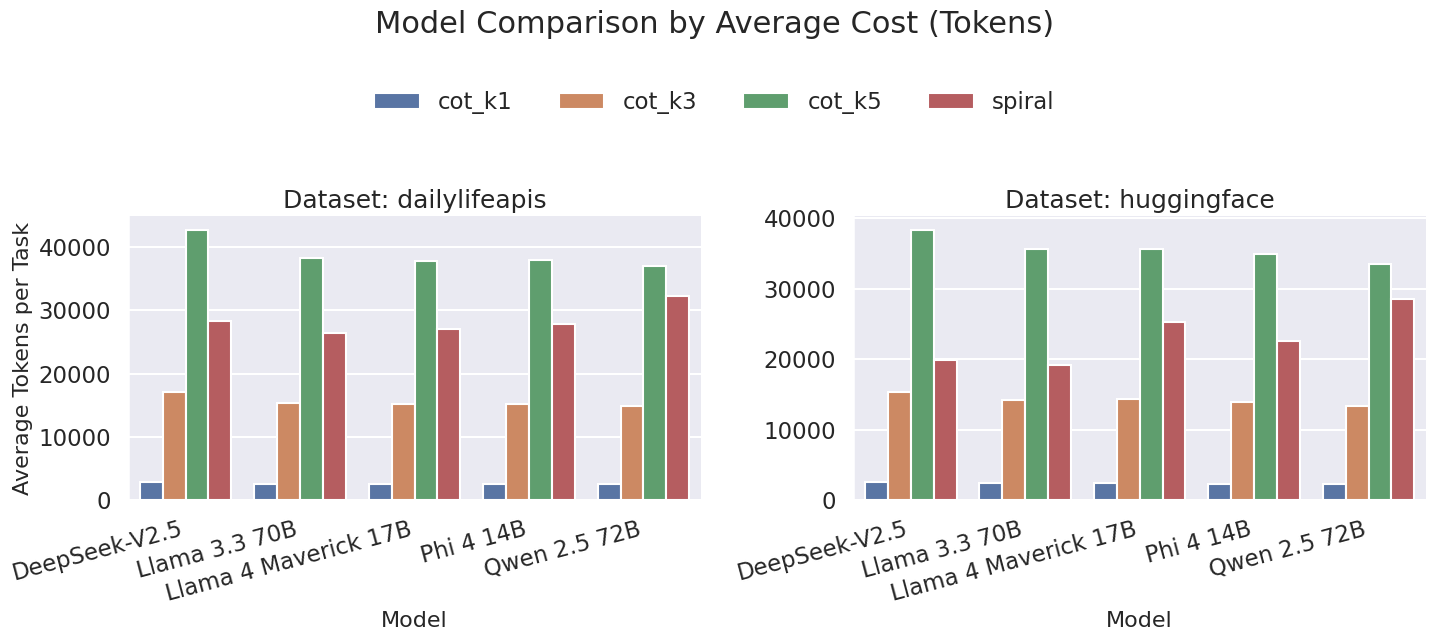

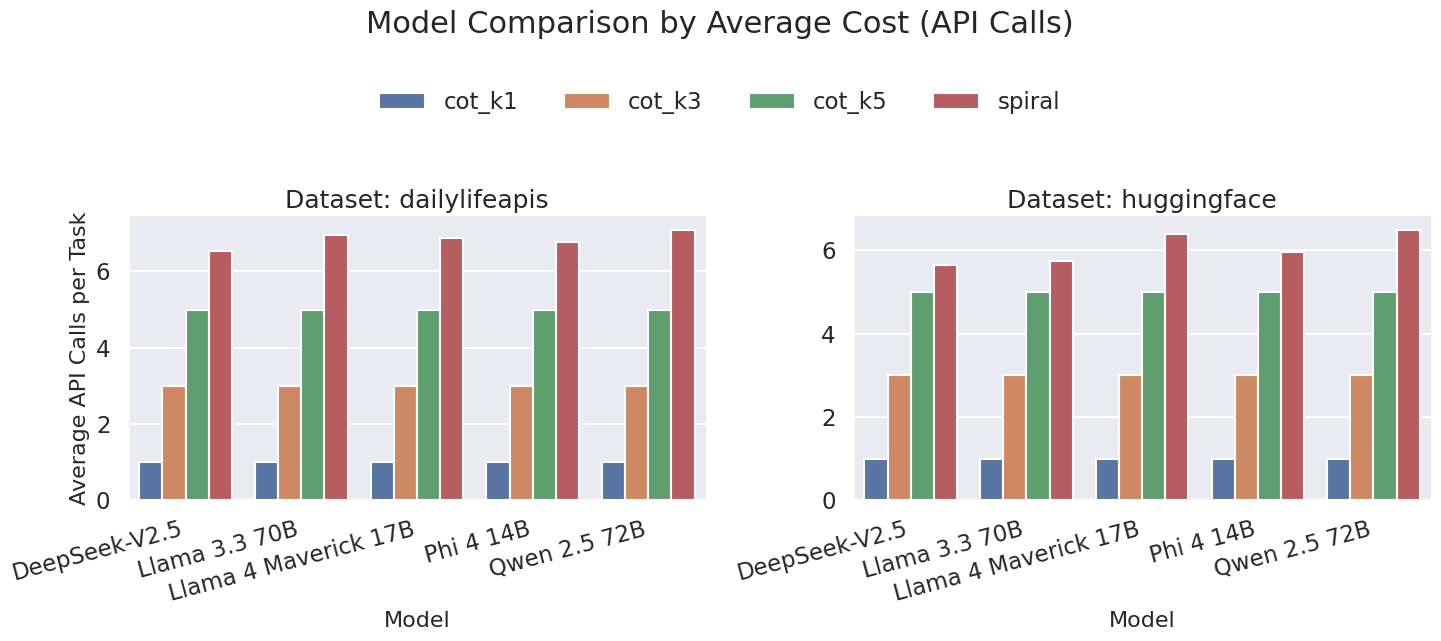

In [5]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Robust Data Parsing ---
# Captures all necessary metrics for both the table and the plots.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]
            
            run_id_match = re.search(r'run_seed_(\d+)', str(file_path))
            run_id = run_id_match.group(1) if run_id_match else file_path.parent.name

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                llm_calls = None
                total_tokens = None

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_calls = search_process.get('expansion_llm_calls', 0)
                    sim_calls = search_process.get('simulation_llm_calls', 0)
                    crit_calls = search_process.get('critic_llm_calls', 0)
                    llm_calls = exp_calls + sim_calls + crit_calls
                    
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                else: # Baseline methods
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    llm_calls = reasoning_cost.get('llm_calls')
                    total_tokens = reasoning_cost.get('total_llm_tokens')

                detailed_data.append({
                    'run_id': str(run_id),
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Solution Conciseness': metrics.get('plan_length'),
                    'Tokens': total_tokens,
                    'API Calls': llm_calls
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna().copy()

models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Generate and Print Solution Conciseness Table ---
if not df_filtered.empty:
    # Set categorical types to enforce order
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Calculate mean per run
    run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
    
    # Calculate final mean and std across runs
    agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
    
    # Format the string for printing
    agg_df_conciseness['Formatted'] = agg_df_conciseness.apply(
        lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1
    )

    # Pivot to create the final table structure
    conciseness_table = agg_df_conciseness.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values='Formatted',
        aggfunc='first'
    )
    
    print("\n" + "="*80)
    print("📊 Solution Conciseness (Average Plan Length)")
    print("="*80)
    print(conciseness_table.to_string())
    print("\n")

    # --- 4. Generate Bar Plots for Average Cost ---
    
    # Aggregate data for plotting
    plot_agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Tokens': 'mean',
        'API Calls': 'mean'
    }).reset_index()

    # --- MODIFICATION: Beautify and compact plots ---
    sns.set_theme(style="darkgrid", context="talk") 

    # Map for aligned model names
    model_name_map = {
        'deepseek_v2_5': 'DeepSeek-V2.5',
        'llama_3_3_70b_instruct': 'Llama 3.3 70B',
        'llama_4': 'Llama 4 Maverick 17B',
        'phi': 'Phi 4 14B',
        'qwen2_5_72b_instruct': 'Qwen 2.5 72B'
    }
    plot_agg_df['model_long_name'] = plot_agg_df['model'].map(model_name_map)
    model_order = [model_name_map[m] for m in sorted(models_to_keep)]


    # Plot 1: Average Tokens
    g_tokens = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='Tokens',
        hue='method',
        col='dataset',
        hue_order=methods_to_keep,
        order=model_order,
        height=6, # Reduced height
        aspect=1.1, # Reduced aspect ratio
        sharey=False
    )
    # Adjust title and legend position for compactness
    g_tokens.fig.suptitle('Model Comparison by Average Cost (Tokens)', y=1.08, fontsize=22)
    sns.move_legend(
        g_tokens, "upper center",
        bbox_to_anchor=(.5, 0.98), # Moved legend down
        ncol=len(methods_to_keep), 
        title=None, 
        frameon=False
    )
    g_tokens.set_axis_labels("Model", "Average Tokens per Task", fontsize=16)
    g_tokens.set_titles("Dataset: {col_name}", size=18)
    g_tokens.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.92]) # Adjust rect to prevent cutoff
    plt.show()

    # Plot 2: Average API Calls
    g_calls = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='API Calls',
        hue='method',
        col='dataset',
        hue_order=methods_to_keep,
        order=model_order,
        height=6, # Reduced height
        aspect=1.1, # Reduced aspect ratio
        sharey=False
    )
    # Adjust title and legend position for compactness
    g_calls.fig.suptitle('Model Comparison by Average Cost (API Calls)', y=1.08, fontsize=22)
    sns.move_legend(
        g_calls, "upper center",
        bbox_to_anchor=(.5, 0.98), # Moved legend down
        ncol=len(methods_to_keep), 
        title=None, 
        frameon=False
    )
    g_calls.set_axis_labels("Model", "Average API Calls per Task", fontsize=16)
    g_calls.set_titles("Dataset: {col_name}", size=18)
    g_calls.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.92]) # Adjust rect to prevent cutoff
    plt.show()

else:
    print("🔴 No data available for analysis after filtering.")



/tmp/ipykernel_1124385/2515839475.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
/tmp/ipykernel_1124385/2515839475.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_1124385/2515839475.py:100: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False


📊 Solution Conciseness (Average Plan Length)
method                                     cot_k1       cot_k3       cot_k5       spiral
dataset       model                                                                     
dailylifeapis deepseek_v2_5           2.82 ± 0.17  2.84 ± 0.15  2.82 ± 0.15  2.74 ± 0.15
              llama_3_3_70b_instruct  3.04 ± 0.17  3.10 ± 0.21  3.09 ± 0.21  2.94 ± 0.13
              llama_4                 2.89 ± 0.18  2.89 ± 0.18  2.92 ± 0.20  2.84 ± 0.13
              phi                     2.77 ± 0.19  2.80 ± 0.19  2.81 ± 0.18  2.69 ± 0.14
              qwen2_5_72b_instruct    2.88 ± 0.19  2.87 ± 0.21  2.91 ± 0.20  2.73 ± 0.16
huggingface   deepseek_v2_5           2.71 ± 0.08  2.60 ± 0.19  2.70 ± 0.07  2.30 ± 0.05
              llama_3_3_70b_instruct  2.77 ± 0.05  2.80 ± 0.10  2.78 ± 0.05  2.28 ± 0.06
              llama_4                 2.57 ± 0.06  2.58 ± 0.07  2.54 ± 0.09  2.35 ± 0.04
              phi                     2.53 ± 0.06  2.57 ± 0.08  

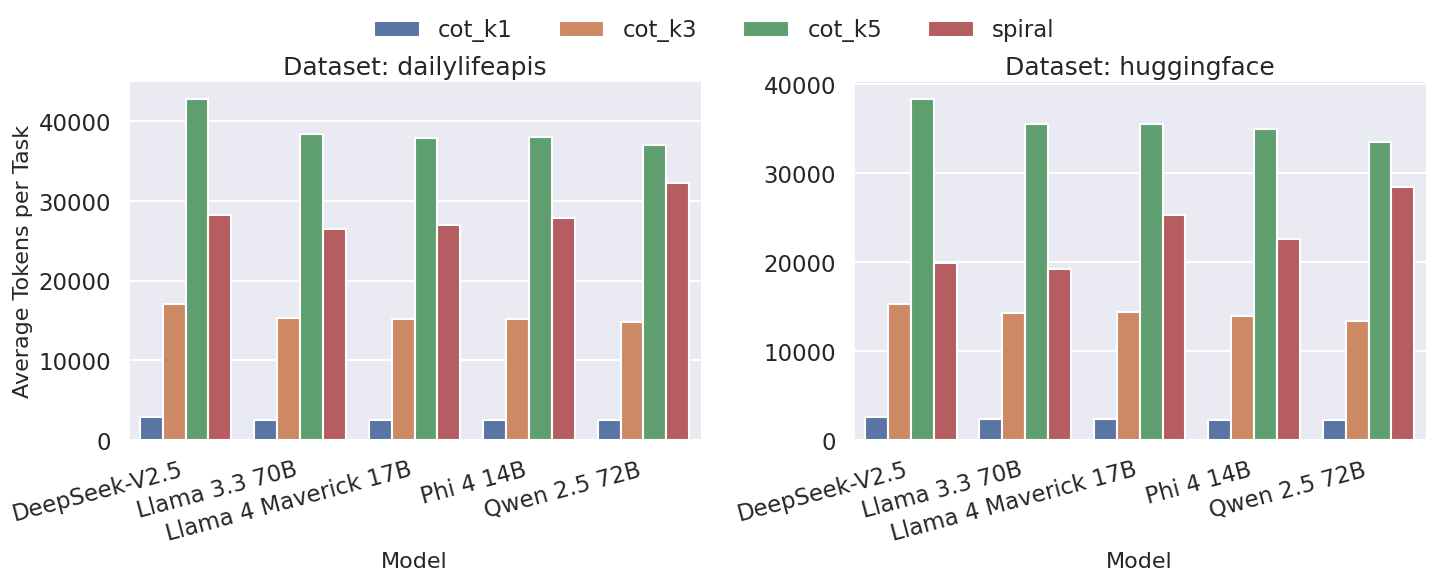

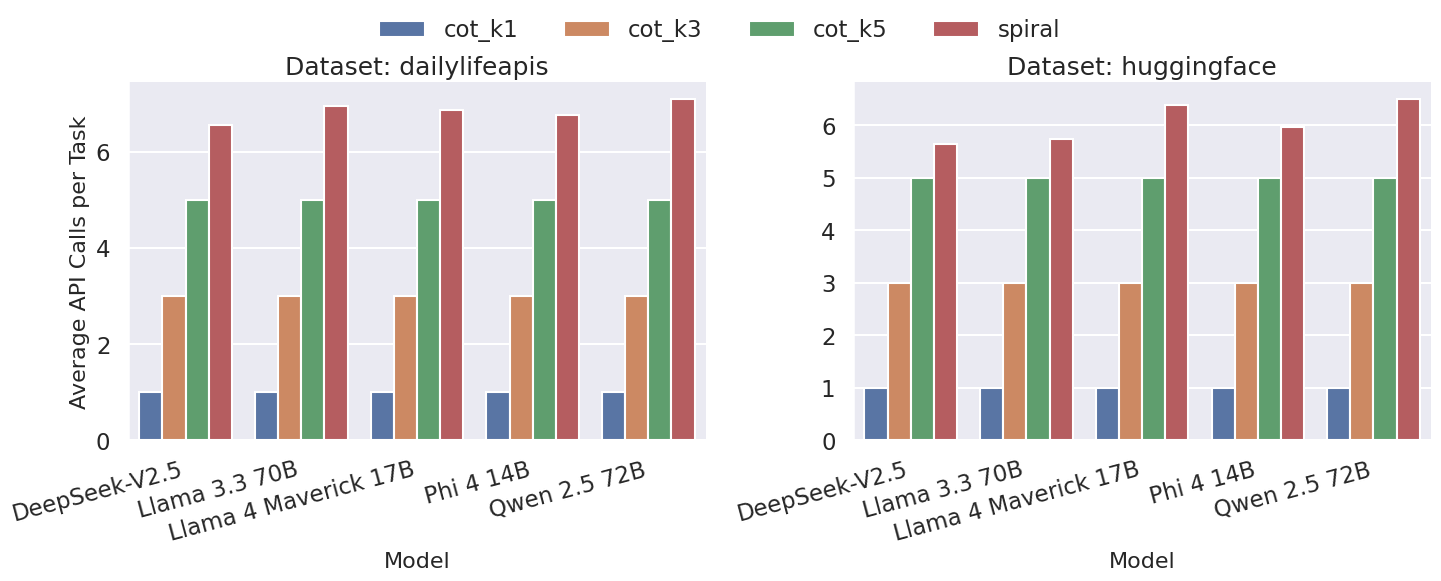

In [6]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Robust Data Parsing ---
# Captures all necessary metrics for both the table and the plots.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]
            
            run_id_match = re.search(r'run_seed_(\d+)', str(file_path))
            run_id = run_id_match.group(1) if run_id_match else file_path.parent.name

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                llm_calls = None
                total_tokens = None

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_calls = search_process.get('expansion_llm_calls', 0)
                    sim_calls = search_process.get('simulation_llm_calls', 0)
                    crit_calls = search_process.get('critic_llm_calls', 0)
                    llm_calls = exp_calls + sim_calls + crit_calls
                    
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                else: # Baseline methods
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    llm_calls = reasoning_cost.get('llm_calls')
                    total_tokens = reasoning_cost.get('total_llm_tokens')

                detailed_data.append({
                    'run_id': str(run_id),
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Solution Conciseness': metrics.get('plan_length'),
                    'Tokens': total_tokens,
                    'API Calls': llm_calls
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna().copy()

models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Generate and Print Solution Conciseness Table ---
if not df_filtered.empty:
    # Set categorical types to enforce order
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Calculate mean per run
    run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
    
    # Calculate final mean and std across runs
    agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
    
    # Format the string for printing
    agg_df_conciseness['Formatted'] = agg_df_conciseness.apply(
        lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1
    )

    # Pivot to create the final table structure
    conciseness_table = agg_df_conciseness.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values='Formatted',
        aggfunc='first'
    )
    
    print("\n" + "="*80)
    print("📊 Solution Conciseness (Average Plan Length)")
    print("="*80)
    print(conciseness_table.to_string())
    print("\n")

    # --- 4. Generate Bar Plots for Average Cost ---
    
    # Aggregate data for plotting
    plot_agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Tokens': 'mean',
        'API Calls': 'mean'
    }).reset_index()

    # --- MODIFICATION: Beautify and compact plots ---
    sns.set_theme(style="darkgrid", context="talk") 

    # Map for aligned model names
    model_name_map = {
        'deepseek_v2_5': 'DeepSeek-V2.5',
        'llama_3_3_70b_instruct': 'Llama 3.3 70B',
        'llama_4': 'Llama 4 Maverick 17B',
        'phi': 'Phi 4 14B',
        'qwen2_5_72b_instruct': 'Qwen 2.5 72B'
    }
    plot_agg_df['model_long_name'] = plot_agg_df['model'].map(model_name_map)
    model_order = [model_name_map[m] for m in sorted(models_to_keep)]


    # Plot 1: Average Tokens
    g_tokens = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='Tokens',
        hue='method',
        col='dataset',
        hue_order=methods_to_keep,
        order=model_order,
        height=6, 
        aspect=1.1,
        sharey=False
    )
    # Adjust legend position and remove plot title
    sns.move_legend(
        g_tokens, "upper center",
        bbox_to_anchor=(.5, 1.0), # Position legend closer to plots
        ncol=len(methods_to_keep), 
        title=None, 
        frameon=False
    )
    g_tokens.set_axis_labels("Model", "Average Tokens per Task", fontsize=16)
    g_tokens.set_titles("Dataset: {col_name}", size=18)
    g_tokens.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for legend
    plt.show()

    # Plot 2: Average API Calls
    g_calls = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='API Calls',
        hue='method',
        col='dataset',
        hue_order=methods_to_keep,
        order=model_order,
        height=6,
        aspect=1.1,
        sharey=False
    )
    # Adjust legend position and remove plot title
    sns.move_legend(
        g_calls, "upper center",
        bbox_to_anchor=(.5, 1.0), # Position legend closer to plots
        ncol=len(methods_to_keep), 
        title=None, 
        frameon=False
    )
    g_calls.set_axis_labels("Model", "Average API Calls per Task", fontsize=16)
    g_calls.set_titles("Dataset: {col_name}", size=18)
    g_calls.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for legend
    plt.show()

else:
    print("🔴 No data available for analysis after filtering.")



/tmp/ipykernel_1124385/499172073.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
/tmp/ipykernel_1124385/499172073.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_1124385/499172073.py:100: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to


📊 Solution Conciseness (Average Plan Length)
method                                     cot_k1       cot_k3       cot_k5       spiral
dataset       model                                                                     
dailylifeapis deepseek_v2_5           2.82 ± 0.17  2.84 ± 0.15  2.82 ± 0.15  2.74 ± 0.15
              llama_3_3_70b_instruct  3.04 ± 0.17  3.10 ± 0.21  3.09 ± 0.21  2.94 ± 0.13
              llama_4                 2.89 ± 0.18  2.89 ± 0.18  2.92 ± 0.20  2.84 ± 0.13
              phi                     2.77 ± 0.19  2.80 ± 0.19  2.81 ± 0.18  2.69 ± 0.14
              qwen2_5_72b_instruct    2.88 ± 0.19  2.87 ± 0.21  2.91 ± 0.20  2.73 ± 0.16
huggingface   deepseek_v2_5           2.71 ± 0.08  2.60 ± 0.19  2.70 ± 0.07  2.30 ± 0.05
              llama_3_3_70b_instruct  2.77 ± 0.05  2.80 ± 0.10  2.78 ± 0.05  2.28 ± 0.06
              llama_4                 2.57 ± 0.06  2.58 ± 0.07  2.54 ± 0.09  2.35 ± 0.04
              phi                     2.53 ± 0.06  2.57 ± 0.08  

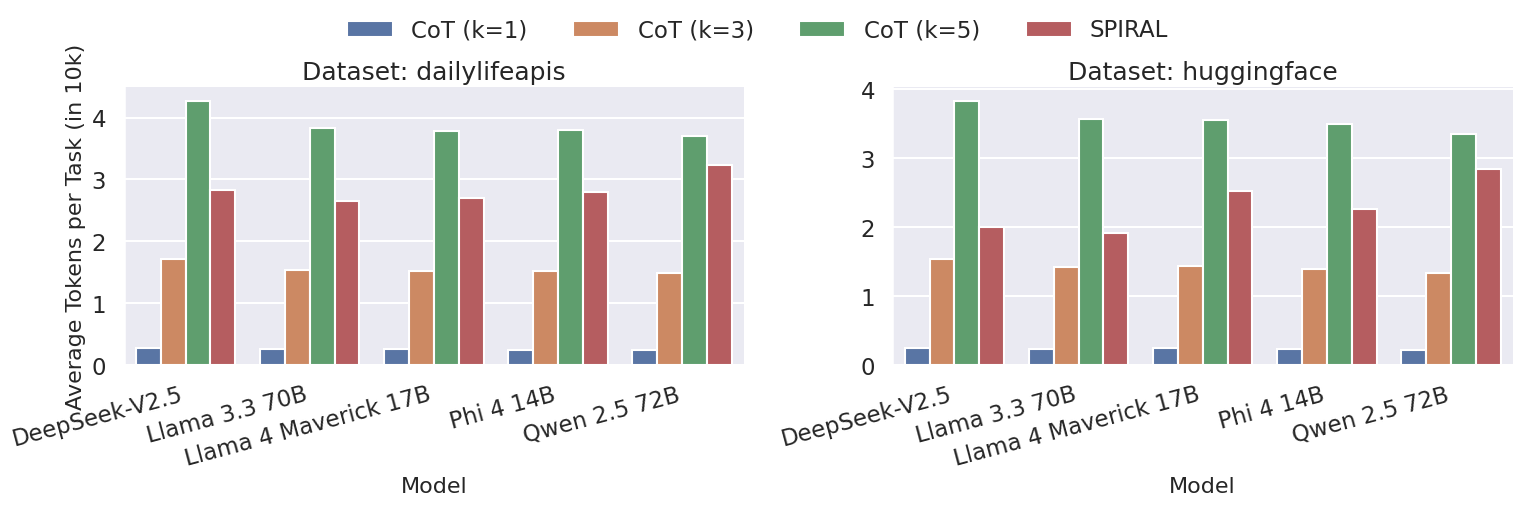

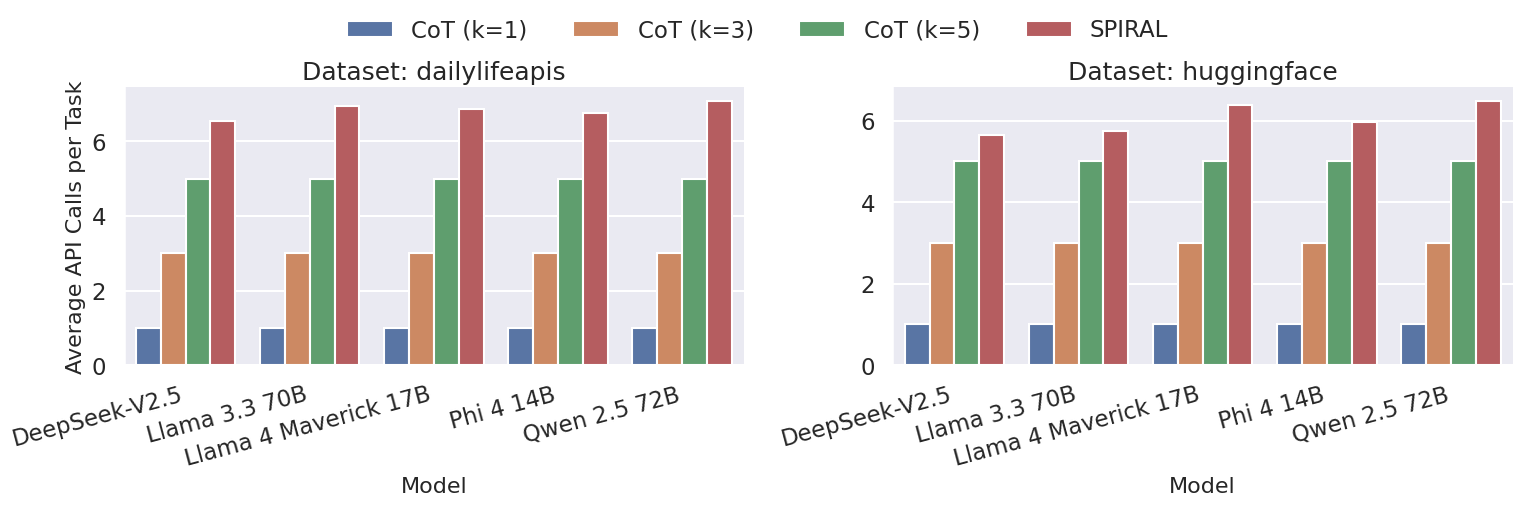

In [7]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Robust Data Parsing ---
# Captures all necessary metrics for both the table and the plots.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]
            
            run_id_match = re.search(r'run_seed_(\d+)', str(file_path))
            run_id = run_id_match.group(1) if run_id_match else file_path.parent.name

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                llm_calls = None
                total_tokens = None

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_calls = search_process.get('expansion_llm_calls', 0)
                    sim_calls = search_process.get('simulation_llm_calls', 0)
                    crit_calls = search_process.get('critic_llm_calls', 0)
                    llm_calls = exp_calls + sim_calls + crit_calls
                    
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                else: # Baseline methods
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    llm_calls = reasoning_cost.get('llm_calls')
                    total_tokens = reasoning_cost.get('total_llm_tokens')

                detailed_data.append({
                    'run_id': str(run_id),
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Solution Conciseness': metrics.get('plan_length'),
                    'Tokens': total_tokens,
                    'API Calls': llm_calls
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna().copy()

models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Generate and Print Solution Conciseness Table ---
if not df_filtered.empty:
    # Set categorical types to enforce order
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Calculate mean per run
    run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
    
    # Calculate final mean and std across runs
    agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
    
    # Format the string for printing
    agg_df_conciseness['Formatted'] = agg_df_conciseness.apply(
        lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1
    )

    # Pivot to create the final table structure
    conciseness_table = agg_df_conciseness.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values='Formatted',
        aggfunc='first'
    )
    
    print("\n" + "="*80)
    print("📊 Solution Conciseness (Average Plan Length)")
    print("="*80)
    print(conciseness_table.to_string())
    print("\n")

    # --- 4. Generate Bar Plots for Average Cost ---
    
    # Aggregate data for plotting
    plot_agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Tokens': 'mean',
        'API Calls': 'mean'
    }).reset_index()
    
    # --- MODIFICATION: Use scientific notation for tokens ---
    plot_agg_df['Tokens (in 10k)'] = plot_agg_df['Tokens'] / 10000

    # --- MODIFICATION: Beautify and compact plots ---
    sns.set_theme(style="darkgrid", context="talk") 

    # Map for aligned model and method names
    model_name_map = {
        'deepseek_v2_5': 'DeepSeek-V2.5',
        'llama_3_3_70b_instruct': 'Llama 3.3 70B',
        'llama_4': 'Llama 4 Maverick 17B',
        'phi': 'Phi 4 14B',
        'qwen2_5_72b_instruct': 'Qwen 2.5 72B'
    }
    method_name_map = {
        'cot_k1': 'CoT (k=1)',
        'cot_k3': 'CoT (k=3)',
        'cot_k5': 'CoT (k=5)',
        'spiral': 'SPIRAL'
    }
    plot_agg_df['model_long_name'] = plot_agg_df['model'].map(model_name_map)
    plot_agg_df['method_long_name'] = plot_agg_df['method'].map(method_name_map)
    
    model_order = [model_name_map[m] for m in sorted(models_to_keep)]
    method_order = [method_name_map[m] for m in methods_to_keep]


    # Plot 1: Average Tokens
    g_tokens = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='Tokens (in 10k)', # Use scaled values
        hue='method_long_name',
        col='dataset',
        hue_order=method_order,
        order=model_order,
        height=5, 
        aspect=1.3,
        sharey=False
    )
    sns.move_legend(
        g_tokens, "upper center",
        bbox_to_anchor=(.5, 1.05), 
        ncol=len(methods_to_keep), 
        title=None, 
        frameon=False
    )
    g_tokens.set_axis_labels("Model", "Average Tokens per Task (in 10k)", fontsize=16)
    g_tokens.set_titles("Dataset: {col_name}", size=18)
    g_tokens.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    # Plot 2: Average API Calls
    g_calls = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='API Calls',
        hue='method_long_name',
        col='dataset',
        hue_order=method_order,
        order=model_order,
        height=5,
        aspect=1.3,
        sharey=False
    )
    sns.move_legend(
        g_calls, "upper center",
        bbox_to_anchor=(.5, 1.05),
        ncol=len(methods_to_keep), 
        title=None, 
        frameon=False
    )
    g_calls.set_axis_labels("Model", "Average API Calls per Task", fontsize=16)
    g_calls.set_titles("Dataset: {col_name}", size=18)
    g_calls.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

else:
    print("🔴 No data available for analysis after filtering.")



/tmp/ipykernel_1677407/3799365949.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
/tmp/ipykernel_1677407/3799365949.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_1677407/3799365949.py:100: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False


📊 Solution Conciseness (Average Plan Length)
method                                     cot_k1       cot_k3       cot_k5       spiral
dataset       model                                                                     
dailylifeapis deepseek_v2_5           2.82 ± 0.17  2.84 ± 0.15  2.82 ± 0.15  2.74 ± 0.15
              llama_3_3_70b_instruct  3.04 ± 0.17  3.10 ± 0.21  3.09 ± 0.21  2.94 ± 0.13
              llama_4                 2.89 ± 0.18  2.89 ± 0.18  2.92 ± 0.20  2.84 ± 0.13
              phi                     2.77 ± 0.19  2.80 ± 0.19  2.81 ± 0.18  2.69 ± 0.14
              qwen2_5_72b_instruct    2.88 ± 0.19  2.87 ± 0.21  2.91 ± 0.20  2.73 ± 0.16
huggingface   deepseek_v2_5           2.71 ± 0.08  2.60 ± 0.19  2.70 ± 0.07  2.30 ± 0.05
              llama_3_3_70b_instruct  2.77 ± 0.05  2.80 ± 0.10  2.78 ± 0.05  2.28 ± 0.06
              llama_4                 2.57 ± 0.06  2.58 ± 0.07  2.54 ± 0.09  2.35 ± 0.04
              phi                     2.53 ± 0.06  2.57 ± 0.08  

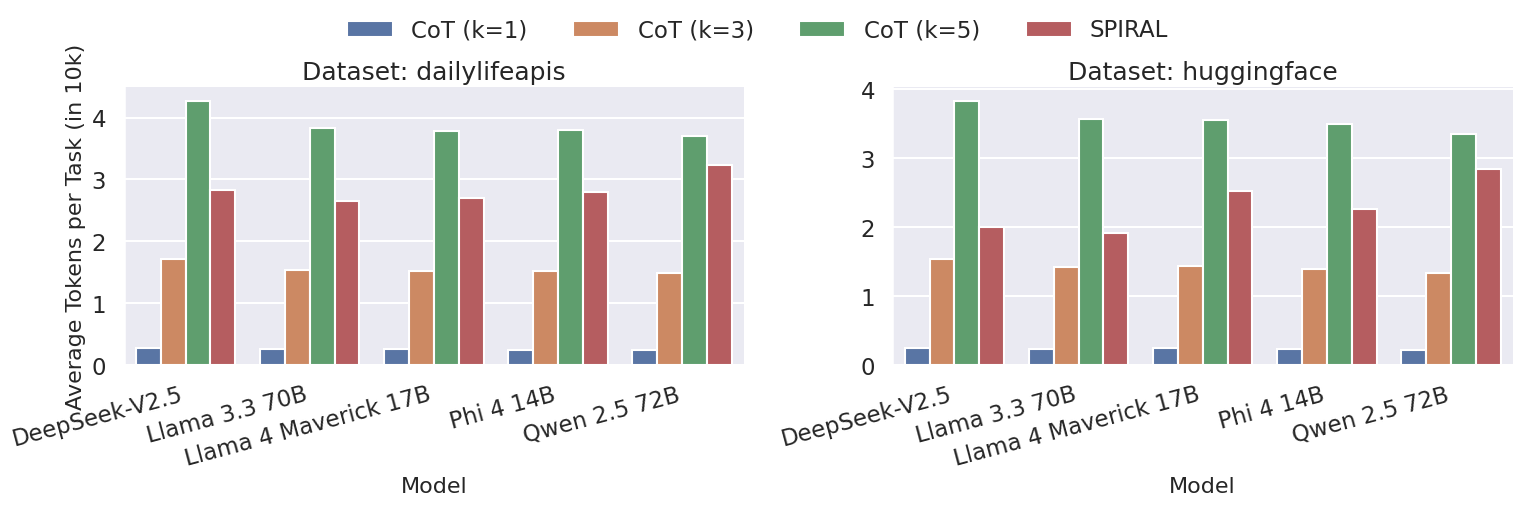

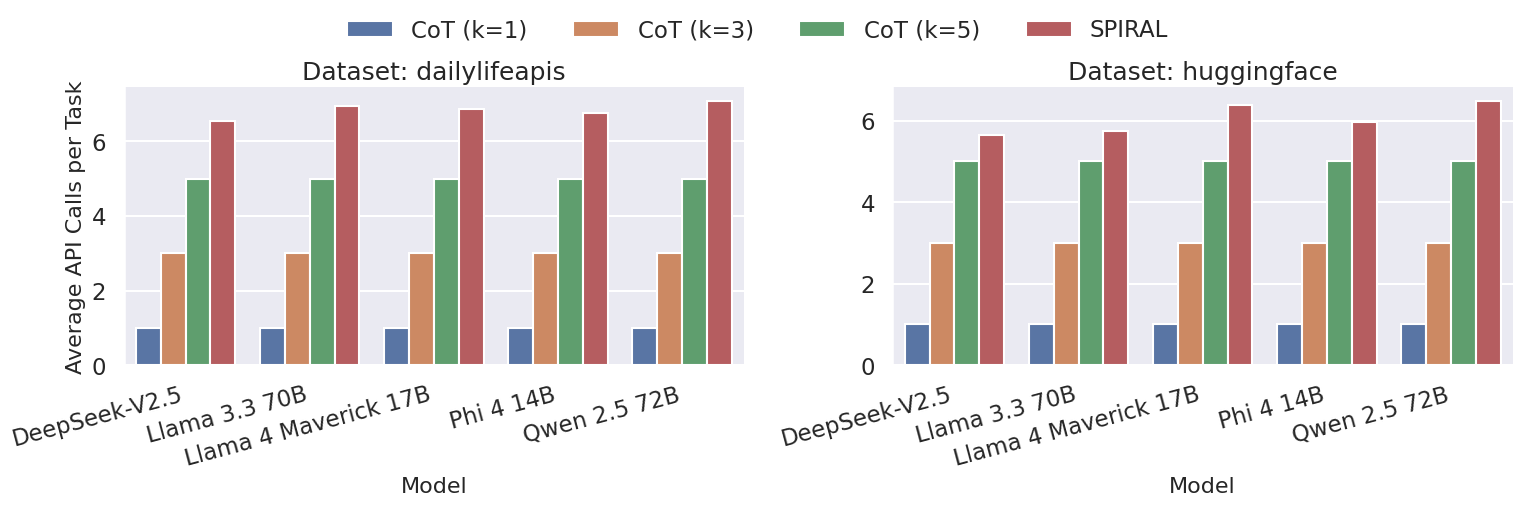

In [1]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Robust Data Parsing ---
# Captures all necessary metrics for both the table and the plots.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]
            
            run_id_match = re.search(r'run_seed_(\d+)', str(file_path))
            run_id = run_id_match.group(1) if run_id_match else file_path.parent.name

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                llm_calls = None
                total_tokens = None

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_calls = search_process.get('expansion_llm_calls', 0)
                    sim_calls = search_process.get('simulation_llm_calls', 0)
                    crit_calls = search_process.get('critic_llm_calls', 0)
                    llm_calls = exp_calls + sim_calls + crit_calls
                    
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                else: # Baseline methods
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    llm_calls = reasoning_cost.get('llm_calls')
                    total_tokens = reasoning_cost.get('total_llm_tokens')

                detailed_data.append({
                    'run_id': str(run_id),
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Solution Conciseness': metrics.get('plan_length'),
                    'Tokens': total_tokens,
                    'API Calls': llm_calls
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna().copy()

models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Generate and Print Solution Conciseness Table ---
if not df_filtered.empty:
    # Set categorical types to enforce order
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Calculate mean per run
    run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
    
    # Calculate final mean and std across runs
    agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
    
    # Format the string for printing
    agg_df_conciseness['Formatted'] = agg_df_conciseness.apply(
        lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1
    )

    # Pivot to create the final table structure
    conciseness_table = agg_df_conciseness.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values='Formatted',
        aggfunc='first'
    )
    
    print("\n" + "="*80)
    print("📊 Solution Conciseness (Average Plan Length)")
    print("="*80)
    print(conciseness_table.to_string())
    print("\n")

    # --- 4. Generate Bar Plots for Average Cost ---
    
    # Aggregate data for plotting
    plot_agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Tokens': 'mean',
        'API Calls': 'mean'
    }).reset_index()
    
    # Use scientific notation for tokens
    plot_agg_df['Tokens (in 10k)'] = plot_agg_df['Tokens'] / 10000

    # Set the plot theme
    sns.set_theme(style="darkgrid", context="talk") 

    # Map for aligned model and method names
    model_name_map = {
        'deepseek_v2_5': 'DeepSeek-V2.5',
        'llama_3_3_70b_instruct': 'Llama 3.3 70B',
        'llama_4': 'Llama 4 Maverick 17B',
        'phi': 'Phi 4 14B',
        'qwen2_5_72b_instruct': 'Qwen 2.5 72B'
    }
    method_name_map = {
        'cot_k1': 'CoT (k=1)',
        'cot_k3': 'CoT (k=3)',
        'cot_k5': 'CoT (k=5)',
        'spiral': 'SPIRAL'
    }
    plot_agg_df['model_long_name'] = plot_agg_df['model'].map(model_name_map)
    plot_agg_df['method_long_name'] = plot_agg_df['method'].map(method_name_map)
    
    model_order = [model_name_map[m] for m in sorted(models_to_keep)]
    method_order = [method_name_map[m] for m in methods_to_keep]


    # Plot 1: Average Tokens
    g_tokens = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='Tokens (in 10k)', 
        hue='method_long_name',
        col='dataset',
        hue_order=method_order,
        order=model_order,
        height=5, 
        aspect=1.3,
        sharey=False
    )
    sns.move_legend(
        g_tokens, "upper center",
        bbox_to_anchor=(.5, 1.05), 
        ncol=len(methods_to_keep), 
        title=None, 
        frameon=False
    )
    g_tokens.set_axis_labels("Model", "Average Tokens per Task (in 10k)", fontsize=16)
    g_tokens.set_titles("Dataset: {col_name}", size=18)
    g_tokens.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    # --- MODIFICATION: Save the plot as a high-resolution PDF ---
    plt.savefig("cost_comparison_tokens.pdf", dpi=300, bbox_inches='tight')
    plt.show()

    # Plot 2: Average API Calls
    g_calls = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='API Calls',
        hue='method_long_name',
        col='dataset',
        hue_order=method_order,
        order=model_order,
        height=5,
        aspect=1.3,
        sharey=False
    )
    sns.move_legend(
        g_calls, "upper center",
        bbox_to_anchor=(.5, 1.05),
        ncol=len(methods_to_keep), 
        title=None, 
        frameon=False
    )
    g_calls.set_axis_labels("Model", "Average API Calls per Task", fontsize=16)
    g_calls.set_titles("Dataset: {col_name}", size=18)
    g_calls.set_xticklabels(rotation=15, ha='right')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    
    # --- MODIFICATION: Save the plot as a high-resolution PDF ---
    plt.savefig("cost_comparison_api_calls.pdf", dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("🔴 No data available for analysis after filtering.")



/tmp/ipykernel_1677407/753936016.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
/tmp/ipykernel_1677407/753936016.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_1677407/753936016.py:100: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to


📊 Solution Conciseness (Average Plan Length)
method                                     cot_k1       cot_k3       cot_k5       spiral
dataset       model                                                                     
dailylifeapis deepseek_v2_5           2.82 ± 0.17  2.84 ± 0.15  2.82 ± 0.15  2.74 ± 0.15
              llama_3_3_70b_instruct  3.04 ± 0.17  3.10 ± 0.21  3.09 ± 0.21  2.94 ± 0.13
              llama_4                 2.89 ± 0.18  2.89 ± 0.18  2.92 ± 0.20  2.84 ± 0.13
              phi                     2.77 ± 0.19  2.80 ± 0.19  2.81 ± 0.18  2.69 ± 0.14
              qwen2_5_72b_instruct    2.88 ± 0.19  2.87 ± 0.21  2.91 ± 0.20  2.73 ± 0.16
huggingface   deepseek_v2_5           2.71 ± 0.08  2.60 ± 0.19  2.70 ± 0.07  2.30 ± 0.05
              llama_3_3_70b_instruct  2.77 ± 0.05  2.80 ± 0.10  2.78 ± 0.05  2.28 ± 0.06
              llama_4                 2.57 ± 0.06  2.58 ± 0.07  2.54 ± 0.09  2.35 ± 0.04
              phi                     2.53 ± 0.06  2.57 ± 0.08  

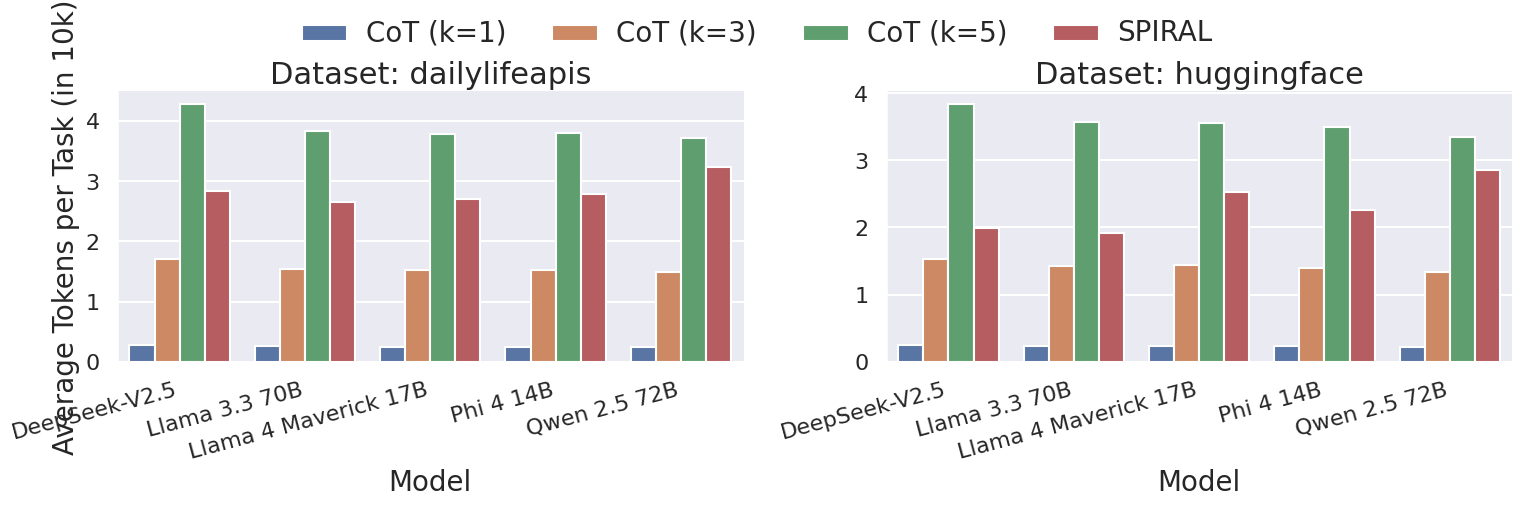

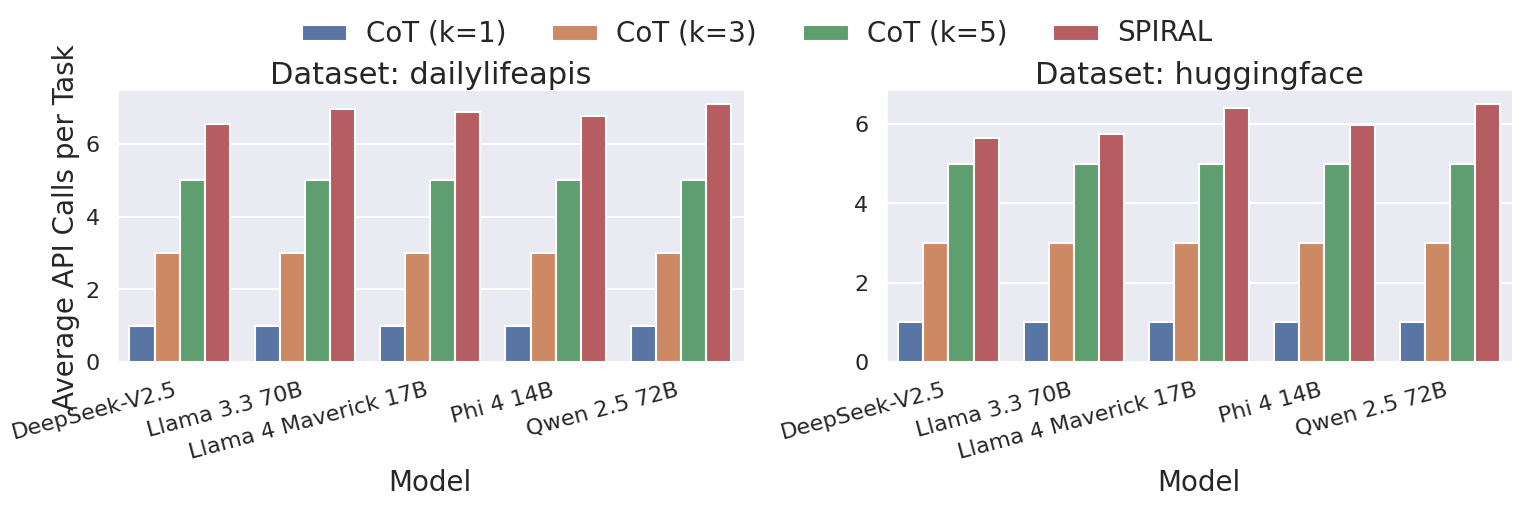

In [2]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Robust Data Parsing ---
# Captures all necessary metrics for both the table and the plots.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]
            
            run_id_match = re.search(r'run_seed_(\d+)', str(file_path))
            run_id = run_id_match.group(1) if run_id_match else file_path.parent.name

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                llm_calls = None
                total_tokens = None

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_calls = search_process.get('expansion_llm_calls', 0)
                    sim_calls = search_process.get('simulation_llm_calls', 0)
                    crit_calls = search_process.get('critic_llm_calls', 0)
                    llm_calls = exp_calls + sim_calls + crit_calls
                    
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                else: # Baseline methods
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    llm_calls = reasoning_cost.get('llm_calls')
                    total_tokens = reasoning_cost.get('total_llm_tokens')

                detailed_data.append({
                    'run_id': str(run_id),
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Solution Conciseness': metrics.get('plan_length'),
                    'Tokens': total_tokens,
                    'API Calls': llm_calls
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna().copy()

models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Generate and Print Solution Conciseness Table ---
if not df_filtered.empty:
    # Set categorical types to enforce order
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Calculate mean per run
    run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
    
    # Calculate final mean and std across runs
    agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
    
    # Format the string for printing
    agg_df_conciseness['Formatted'] = agg_df_conciseness.apply(
        lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1
    )

    # Pivot to create the final table structure
    conciseness_table = agg_df_conciseness.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values='Formatted',
        aggfunc='first'
    )
    
    print("\n" + "="*80)
    print("📊 Solution Conciseness (Average Plan Length)")
    print("="*80)
    print(conciseness_table.to_string())
    print("\n")

    # --- 4. Generate Bar Plots for Average Cost ---
    
    # Aggregate data for plotting
    plot_agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Tokens': 'mean',
        'API Calls': 'mean'
    }).reset_index()
    
    # Use scientific notation for tokens
    plot_agg_df['Tokens (in 10k)'] = plot_agg_df['Tokens'] / 10000

    # Set the plot theme
    sns.set_theme(style="darkgrid", context="talk") 

    # Map for aligned model and method names
    model_name_map = {
        'deepseek_v2_5': 'DeepSeek-V2.5',
        'llama_3_3_70b_instruct': 'Llama 3.3 70B',
        'llama_4': 'Llama 4 Maverick 17B',
        'phi': 'Phi 4 14B',
        'qwen2_5_72b_instruct': 'Qwen 2.5 72B'
    }
    method_name_map = {
        'cot_k1': 'CoT (k=1)',
        'cot_k3': 'CoT (k=3)',
        'cot_k5': 'CoT (k=5)',
        'spiral': 'SPIRAL'
    }
    plot_agg_df['model_long_name'] = plot_agg_df['model'].map(model_name_map)
    plot_agg_df['method_long_name'] = plot_agg_df['method'].map(method_name_map)
    
    model_order = [model_name_map[m] for m in sorted(models_to_keep)]
    method_order = [method_name_map[m] for m in methods_to_keep]


    # Plot 1: Average Tokens
    g_tokens = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='Tokens (in 10k)', 
        hue='method_long_name',
        col='dataset',
        hue_order=method_order,
        order=model_order,
        height=5, 
        aspect=1.3,
        sharey=False
    )
    # --- MODIFICATION: Increase all font sizes ---
    sns.move_legend(
        g_tokens, "upper center",
        bbox_to_anchor=(.5, 1.05), 
        ncol=len(methods_to_keep), 
        title=None, 
        frameon=False
    )
    plt.setp(g_tokens.legend.get_texts(), fontsize='20') # Legend font size
    g_tokens.set_axis_labels("Model", "Average Tokens per Task (in 10k)", fontsize=20) # Axis label font size
    g_tokens.set_titles("Dataset: {col_name}", size=22) # Title font size
    g_tokens.set_xticklabels(rotation=15, ha='right', fontsize=16) # X-tick label font size
    for ax in g_tokens.axes.flat:
        ax.tick_params(axis='y', labelsize=16) # Y-tick label font size

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig("cost_comparison_tokens.pdf", dpi=300, bbox_inches='tight')
    plt.show()

    # Plot 2: Average API Calls
    g_calls = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='API Calls',
        hue='method_long_name',
        col='dataset',
        hue_order=method_order,
        order=model_order,
        height=5,
        aspect=1.3,
        sharey=False
    )
    # --- MODIFICATION: Increase all font sizes ---
    sns.move_legend(
        g_calls, "upper center",
        bbox_to_anchor=(.5, 1.05),
        ncol=len(methods_to_keep), 
        title=None, 
        frameon=False
    )
    plt.setp(g_calls.legend.get_texts(), fontsize='20') # Legend font size
    g_calls.set_axis_labels("Model", "Average API Calls per Task", fontsize=20) # Axis label font size
    g_calls.set_titles("Dataset: {col_name}", size=22) # Title font size
    g_calls.set_xticklabels(rotation=15, ha='right', fontsize=16) # X-tick label font size
    for ax in g_calls.axes.flat:
        ax.tick_params(axis='y', labelsize=16) # Y-tick label font size

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig("cost_comparison_api_calls.pdf", dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("🔴 No data available for analysis after filtering.")



/tmp/ipykernel_1677407/318525849.py:89: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
/tmp/ipykernel_1677407/318525849.py:92: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
/tmp/ipykernel_1677407/318525849.py:100: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to


📊 Solution Conciseness (Average Plan Length)
method                                     cot_k1       cot_k3       cot_k5       spiral
dataset       model                                                                     
dailylifeapis deepseek_v2_5           2.82 ± 0.17  2.84 ± 0.15  2.82 ± 0.15  2.74 ± 0.15
              llama_3_3_70b_instruct  3.04 ± 0.17  3.10 ± 0.21  3.09 ± 0.21  2.94 ± 0.13
              llama_4                 2.89 ± 0.18  2.89 ± 0.18  2.92 ± 0.20  2.84 ± 0.13
              phi                     2.77 ± 0.19  2.80 ± 0.19  2.81 ± 0.18  2.69 ± 0.14
              qwen2_5_72b_instruct    2.88 ± 0.19  2.87 ± 0.21  2.91 ± 0.20  2.73 ± 0.16
huggingface   deepseek_v2_5           2.71 ± 0.08  2.60 ± 0.19  2.70 ± 0.07  2.30 ± 0.05
              llama_3_3_70b_instruct  2.77 ± 0.05  2.80 ± 0.10  2.78 ± 0.05  2.28 ± 0.06
              llama_4                 2.57 ± 0.06  2.58 ± 0.07  2.54 ± 0.09  2.35 ± 0.04
              phi                     2.53 ± 0.06  2.57 ± 0.08  

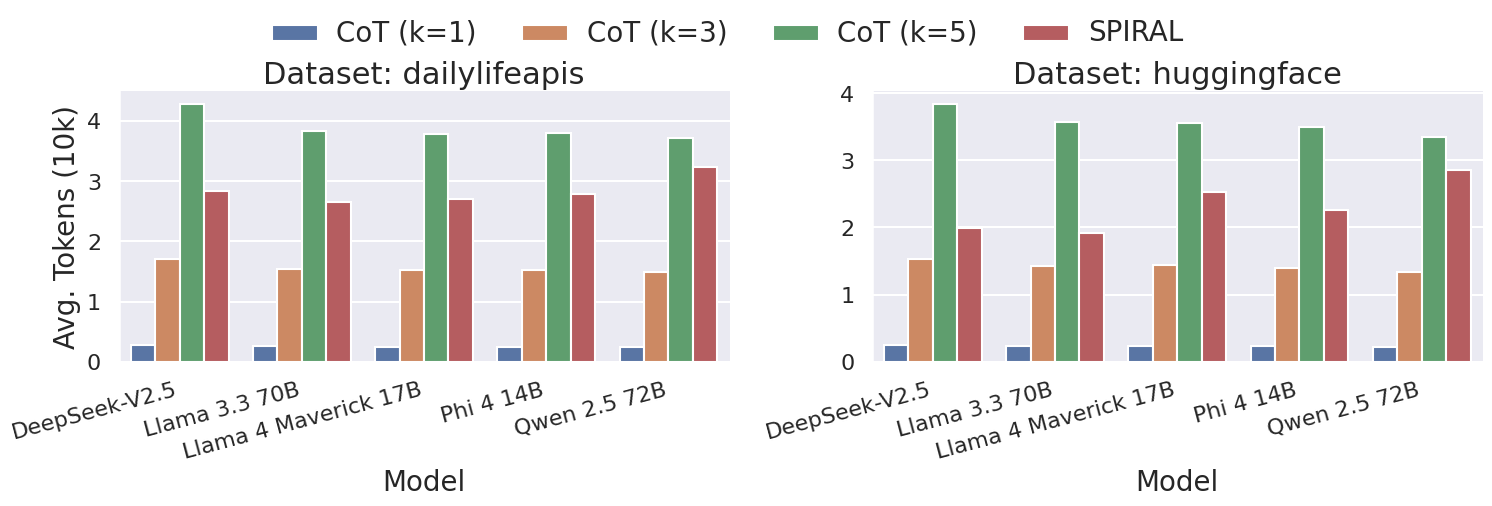

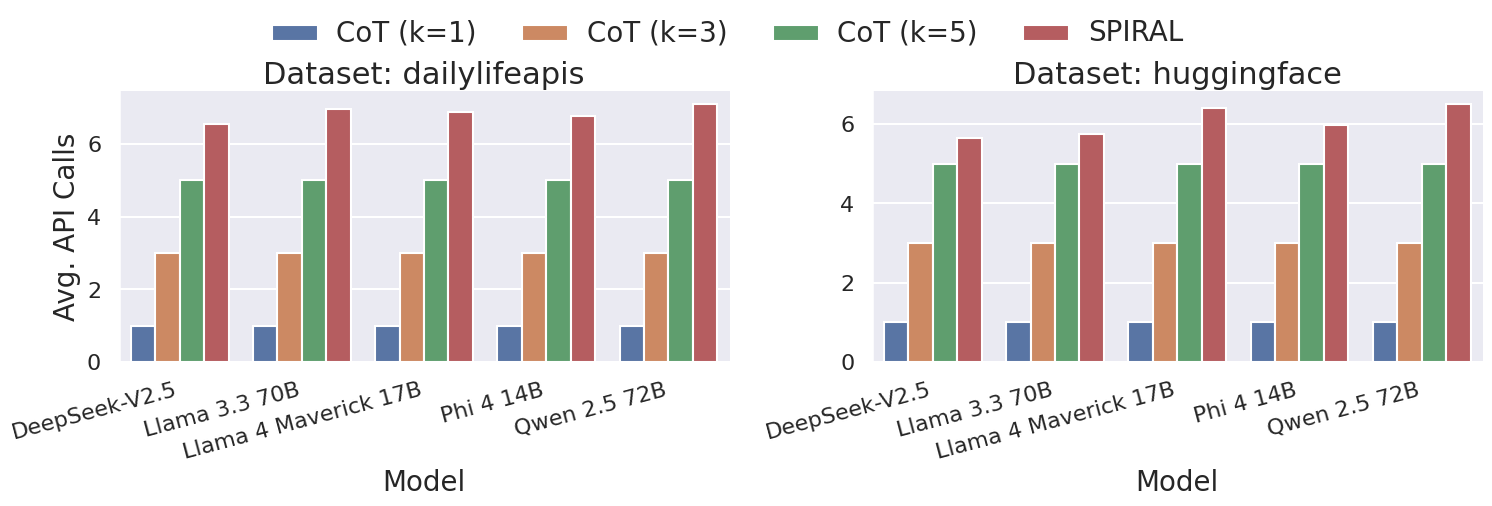

In [3]:
import json
import pandas as pd
from pathlib import Path
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Robust Data Parsing ---
# Captures all necessary metrics for both the table and the plots.
root_dir = Path('.')
detailed_data = []
ALL_EXPECTED_METHODS = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']
results_files = root_dir.glob('**/results.json')

for file_path in results_files:
    try:
        parts = file_path.parts
        current_method = None
        for m in ALL_EXPECTED_METHODS:
            if m in parts:
                current_method = m
                break
        
        if current_method:
            method_index = parts.index(current_method)
            dataset = parts[method_index + 1].replace('_experiments', '').replace('_v3', '')
            model = parts[method_index + 2]
            
            run_id_match = re.search(r'run_seed_(\d+)', str(file_path))
            run_id = run_id_match.group(1) if run_id_match else file_path.parent.name

            with open(file_path, 'r') as f:
                results_list = json.load(f)

            for item in results_list:
                metrics = item.get('metrics', {})
                llm_calls = None
                total_tokens = None

                if current_method == 'spiral':
                    search_process = metrics.get('search_process', {})
                    exp_calls = search_process.get('expansion_llm_calls', 0)
                    sim_calls = search_process.get('simulation_llm_calls', 0)
                    crit_calls = search_process.get('critic_llm_calls', 0)
                    llm_calls = exp_calls + sim_calls + crit_calls
                    
                    exp_tokens = search_process.get('expansion_llm_tokens', 0)
                    sim_tokens = search_process.get('simulation_llm_tokens', 0)
                    crit_tokens = search_process.get('critic_llm_tokens', 0)
                    total_tokens = exp_tokens + sim_tokens + crit_tokens
                else: # Baseline methods
                    reasoning_cost = metrics.get('reasoning_cost', {})
                    llm_calls = reasoning_cost.get('llm_calls')
                    total_tokens = reasoning_cost.get('total_llm_tokens')

                detailed_data.append({
                    'run_id': str(run_id),
                    'method': current_method, 'dataset': dataset, 'model': model,
                    'Solution Conciseness': metrics.get('plan_length'),
                    'Tokens': total_tokens,
                    'API Calls': llm_calls
                })
    except Exception as e:
        print(f"🔴 Skipping file due to error: {file_path} -> {e}")

# --- 2. Data Cleaning and Preparation ---
df_raw = pd.DataFrame(detailed_data)
df_cleaned = df_raw.dropna().copy()

models_to_keep = [
    'deepseek_v2_5', 'llama_3_3_70b_instruct', 'llama_4', 
    'phi', 'qwen2_5_72b_instruct'
]
methods_to_keep = ['cot_k1', 'cot_k3', 'cot_k5', 'spiral']

df_filtered = df_cleaned[
    df_cleaned['model'].isin(models_to_keep) & 
    df_cleaned['method'].isin(methods_to_keep)
].copy()

# --- 3. Generate and Print Solution Conciseness Table ---
if not df_filtered.empty:
    # Set categorical types to enforce order
    df_filtered['model'] = pd.Categorical(df_filtered['model'], categories=sorted(models_to_keep), ordered=True)
    df_filtered['method'] = pd.Categorical(df_filtered['method'], categories=methods_to_keep, ordered=True)

    # Calculate mean per run
    run_means = df_filtered.groupby(['dataset', 'model', 'method', 'run_id'])['Solution Conciseness'].mean().reset_index()
    
    # Calculate final mean and std across runs
    agg_df_conciseness = run_means.groupby(['dataset', 'model', 'method'])['Solution Conciseness'].agg(['mean', 'std']).reset_index()
    
    # Format the string for printing
    agg_df_conciseness['Formatted'] = agg_df_conciseness.apply(
        lambda row: f"{row['mean']:.2f} ± {row['std']:.2f}", axis=1
    )

    # Pivot to create the final table structure
    conciseness_table = agg_df_conciseness.pivot_table(
        index=['dataset', 'model'],
        columns='method',
        values='Formatted',
        aggfunc='first'
    )
    
    print("\n" + "="*80)
    print("📊 Solution Conciseness (Average Plan Length)")
    print("="*80)
    print(conciseness_table.to_string())
    print("\n")

    # --- 4. Generate Bar Plots for Average Cost ---
    
    # Aggregate data for plotting
    plot_agg_df = df_filtered.groupby(['dataset', 'model', 'method']).agg({
        'Tokens': 'mean',
        'API Calls': 'mean'
    }).reset_index()
    
    # Use scientific notation for tokens
    plot_agg_df['Tokens (in 10k)'] = plot_agg_df['Tokens'] / 10000

    # Set the plot theme
    sns.set_theme(style="darkgrid", context="talk") 

    # Map for aligned model and method names
    model_name_map = {
        'deepseek_v2_5': 'DeepSeek-V2.5',
        'llama_3_3_70b_instruct': 'Llama 3.3 70B',
        'llama_4': 'Llama 4 Maverick 17B',
        'phi': 'Phi 4 14B',
        'qwen2_5_72b_instruct': 'Qwen 2.5 72B'
    }
    method_name_map = {
        'cot_k1': 'CoT (k=1)',
        'cot_k3': 'CoT (k=3)',
        'cot_k5': 'CoT (k=5)',
        'spiral': 'SPIRAL'
    }
    plot_agg_df['model_long_name'] = plot_agg_df['model'].map(model_name_map)
    plot_agg_df['method_long_name'] = plot_agg_df['method'].map(method_name_map)
    
    model_order = [model_name_map[m] for m in sorted(models_to_keep)]
    method_order = [method_name_map[m] for m in methods_to_keep]


    # Plot 1: Average Tokens
    g_tokens = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='Tokens (in 10k)', 
        hue='method_long_name',
        col='dataset',
        hue_order=method_order,
        order=model_order,
        height=5, 
        aspect=1.3,
        sharey=False
    )
    sns.move_legend(
        g_tokens, "upper center",
        bbox_to_anchor=(.5, 1.05), 
        ncol=len(methods_to_keep), 
        title=None, 
        frameon=False
    )
    # --- MODIFICATION: Abbreviate Y-axis label ---
    g_tokens.set_axis_labels("Model", "Avg. Tokens (10k)", fontsize=20) 
    g_tokens.set_titles("Dataset: {col_name}", size=22) 
    g_tokens.set_xticklabels(rotation=15, ha='right', fontsize=16) 
    plt.setp(g_tokens.legend.get_texts(), fontsize='20') 
    for ax in g_tokens.axes.flat:
        ax.tick_params(axis='y', labelsize=16) 

    plt.tight_layout(rect=[0.02, 0, 1, 0.98]) # Give a little more left padding
    plt.savefig("cost_comparison_tokens.pdf", dpi=300, bbox_inches='tight')
    plt.show()

    # Plot 2: Average API Calls
    g_calls = sns.catplot(
        data=plot_agg_df,
        kind='bar',
        x='model_long_name',
        y='API Calls',
        hue='method_long_name',
        col='dataset',
        hue_order=method_order,
        order=model_order,
        height=5,
        aspect=1.3,
        sharey=False
    )
    sns.move_legend(
        g_calls, "upper center",
        bbox_to_anchor=(.5, 1.05),
        ncol=len(methods_to_keep), 
        title=None, 
        frameon=False
    )
    # --- MODIFICATION: Abbreviate Y-axis label ---
    g_calls.set_axis_labels("Model", "Avg. API Calls", fontsize=20)
    g_calls.set_titles("Dataset: {col_name}", size=22)
    g_calls.set_xticklabels(rotation=15, ha='right', fontsize=16)
    plt.setp(g_calls.legend.get_texts(), fontsize='20')
    for ax in g_calls.axes.flat:
        ax.tick_params(axis='y', labelsize=16)

    plt.tight_layout(rect=[0.02, 0, 1, 0.98]) # Give a little more left padding
    plt.savefig("cost_comparison_api_calls.pdf", dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("🔴 No data available for analysis after filtering.")

